<a href="https://colab.research.google.com/github/taipm/Books.GoogleDev.Club/blob/master/Stock_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chương trình này dùng để phân tích chuyên sâu về một mã chứng khoán nào đó.

Các vấn đề chính bao gồm:

1. Lấy lịch sử giá, khối lượng, ...
2. Phân tích dòng tiền.
3. Phân tích điểm pivot
4. Phân tích diễn biến khối ngoại


CỔ PHIẾU MẠNH: NHƯ THẾ NÀO ĐƯỢC XEM LÀ MẠNH ?
1. Có giá tăng, thường thì tăng ở bước khởi động sẽ tốt, một khoảng tăng 2-3% khởi đầu là có ý nghĩa. Tuy nhiên tăng mạnh quá rồi thì phải cẩn thận chút xem xét chút.
2. Đi kèm với giá thì phải là khối lượng, giá tăng mà khối lượng không tăng tương xứng thì không có ý nghĩa lắm.
3. Một cổ phiếu có thanh khoản lớn (tương ứng giá trị giao dịch lớn tăng) sẽ có đà tăng (được xác nhận) mạnh hơn. Xe lu chuyển bánh khó hơn xe máy.
4. Ta đi lọc mấy con này, sau đó tìm con phù hợp để vào.


In [ ]:
!pip install beautifulsoup4
!pip install lxml
!pip install pandas
!pip install html-table-extractor
!pip install schedule
!pip install python-wordpress-xmlrpc
!pip install beautifulsoup4
!pip install lxml
!pip install pandas
!pip install html-table-extractor
!pip install XlsxWriter
!pip install telegram
!pip install matplotlib

import numpy as np
import requests
from bs4 import BeautifulSoup
import urllib.request
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
from html_table_extractor.extractor import Extractor
import re
import pandas as pd
import tabulate as tabulate
import sys
import matplotlib.pyplot as plt
import datetime
from wordpress_xmlrpc import Client, WordPressPost
from wordpress_xmlrpc.methods.posts import GetPosts, NewPost, EditPost
from wordpress_xmlrpc.methods.users import GetUserInfo
import numpy as np
import time

In [ ]:
# def Get_All_Stocks_2(): #Sẽ loại hàm này
#   #[stock, price, vol, margin, max_52_tuan, min_52_tuan, max_in_day, min_in_day, info_now]
#   url = "https://vuichungkhoan.blogspot.com/2020/11/danh-muc-chung-khoan.html"
#   response = requests.get(url, verify=False)
#   soup = BeautifulSoup(response.text, "html.parser")
#   html = soup.findAll('div', {"class": "post-body entry-content float-container"})
#   content = html[0].find('p').text
#   stocks = content.split(",")
#   return stocks
#print(Get_All_Stocks)
#print(len(Get_All_Stocks()))


def Get_All_Stocks():
  #year = 
  df = pd.read_html('https://alphacodeclub.wordpress.com/2021/03/23/data-2021-03-23/',header=0)[0]
  newDf = df.iloc[:, 1:]
  #print(newDf)
  stocks = newDf['Cổ phiếu'].to_numpy()
  print(stocks)
  return stocks

#Get_All_Stocks()
def percent(a, b):
  rs = ((a - b)/b)*100
  return rs
 
def buildDetailUrl(stock):
    url = 'https://www.cophieu68.vn/snapshot.php?id=' + stock
    return url
 
def buildSoup(url):
   page = urllib.request.urlopen(url)
   soup = BeautifulSoup(page, 'html.parser')
   return soup.encode("utf-8")
 
def GetLinks(stock, html, n):
    links = []
    soup = BeautifulSoup(html, "html.parser")
    for link in soup.findAll('a'):
        href = link.get("href")
        if (stock.lower() in href) and ("newsid" in href):
            links.append(href)
            #print(href)
    if len(links) >= n:
        return links[0:n]
    else:
        return links
 
def GetDetail(stock):
    if(stock == "INDEX"):
        return
    elif (len(stock.strip()) > 3):
        return
    elif (len(stock.strip()) < 3):
        return
    else:
        url = buildDetailUrl(stock)
        response = requests.get(url, verify=False)
        #_news = GetLinks(stock, response.text,5)
        #_str_news = "\n\nTin tức liên quan: \n"+ '\n'.join(_news)
        #print(_str_news)
        soup = BeautifulSoup(response.text, "html.parser")
        # stock_name = soup.select('h1')[0].text.strip()
        # print(stock_name.decode('utf-8'))
        #Vol
        items = soup.findAll('strong', {"id": 'stockname_volume'})
        vol = float(items[0].get_text().replace(",", ""))
        #print("Vol: " + str(vol))
        #Price
        items = soup.findAll('strong', {"id": 'stockname_close'})
        price = float(items[0].get_text())
        #print("Price: " + str(price))
        #money
        money = (price*vol)/1000000 #Tỷ
        #Margin
        items = soup.findAll('strong', {"id": 'stockname_change'})
        margin = items[0].get_text().split()[1][1:len(items[0].get_text().split()[1])-2]
        margin = float(margin)
        #print("margin: " + str(margin))
 
        table = soup.findAll('div', {"id": "snapshot_trading"})
        #print(table)
        if(len(table) == 0):
            print("Mã cổ phiếu sai hoặc không lấy được thông tin cổ phiếu")
            return -1
        else:
          try:
                #Bảng thứ 2
                _tables = soup.findAll(lambda tag: tag.name == 'table')
                _x = _tables[2]  # Bảng thứ 2
                rows = _x.findAll(lambda tag: tag.name == 'tr')
                i = 0
                tablePrices = []
                for cell in rows:
                    th = cell.find_all('th')
                    th_data = [col.text.strip('\n') for col in th]
                    td = cell.find_all('td')
                    row = [i.text.replace('\n', '') for i in td]
                    #print(row)
                    tablePrices.insert(i, row)
                    i = i+1
                #print(tablePrices)
                Eps = tablePrices[0][1].strip().split('\t')[0].strip() + " (ngàn)"
                Pe = tablePrices[1][1].strip().replace(",", "").split(' ')[0].strip()
                Von_Hoa = tablePrices[2][1].strip().split(' ')[0].strip().replace(",", "") + " (tỷ)"
                KL_Luu_Hanh = tablePrices[3][1].strip().split(' ')[0].strip() + " (triệu)"
                #Gia chào sàn - hàng 4
                Roe = tablePrices[5][1].strip().split('%')[0]
                Beta = tablePrices[6][1].strip()
 
                _info_basic = "\nThông tin tài chính cơ bản: "
                _info_basic = _info_basic + "\n- PE: " + Pe + "\n- EPS: " + Eps + "\n" + "- ROE: " + Roe + " (%)\n" + "- Beta: " +\
                    Beta + "\n" + "- KL lưu hành: " + KL_Luu_Hanh + "\n" + "- Vốn hóa TT: " + Von_Hoa
                #print(_info_basic)
                warning = ""
                if(float(Pe) >= 20):
                    warning = warning + "\n- P/E quá cao. Nên đánh giá thận trọng."
                if(float(Beta) <= 0.8):
                    warning = warning + \
                    "\n- Beta quá thấp (diễn biến trái chiều thị trường). Nên đánh giá thận trọng."
                if(float(Roe) <= 10):
                    warning = warning + "\n- ROE quá thấp. Bạn nên đánh giá lại doanh nghiệp."
                if(len(warning) > 0):
                    _info_basic = _info_basic + "\n==>LƯU Ý: " + warning
                #print(_info_basic)
                tr = table[0].findAll(['tr'])[1:]
                tablePrices = []
                i = 0
                for cell in tr:
                    th = cell.find_all('th')
                    th_data = [col.text.strip('\n') for col in th]
                    td = cell.find_all('td')
                    row = [i.text.replace('\n', '') for i in td]
                    tablePrices.insert(i, row)
                    i = i+1
                
                max_52_tuan = float(tablePrices[5][1])
                min_52_tuan = float(tablePrices[6][1])
                min_in_day = float(tablePrices[1][1].strip().split(' ')[0])
                max_in_day = float(tablePrices[1][1].strip().split('\t')[1].strip())
                vol_10_day = float(tablePrices[4][1].replace(",",""))
                vol_13_tuan = float(tablePrices[3][1].replace(",",""))
 
                price = price
                vol = vol
                margin = margin
                _margin_52 = percent(price, max_52_tuan)
                #print("%52: " + str(_margin_52))
                info_now = ""
                _stock_info = "Mã: " + stock.upper()#StockManager.GetStock(stock)
             
                if(max_in_day != 0) and (min_in_day != 0):
                    info_now = stock + " : " + str(price) + " : " + str(margin) + \
                        " (%) - " + str(max_in_day) + " | " + str(min_in_day) + \
                        " | Biên độ: " + str('{:,.2f}'.format(percent(max_in_day, min_in_day))) + " (%)" +\
                        "\nĐạt " + str('{:,.2f}'.format(_margin_52)) + " (%) đỉnh 52 tuần" +\
                        "\n - KLHT: " + str('{:,.2f}'.format(vol)) + " ~ " + str('{:,.2f}'.format((price*vol)/1000000)) + " (tỷ)" +\
                        "\n - KLTB 10 ngày: " + str('{:,.2f}'.format(vol_10_day)) + " | " +\
                        str('{:,.2f}'.format(percent(vol, vol_10_day))) +\
                        " (%)\n - KLTB 13 tuần: " + \
                        str('{:,.2f}'.format(vol_13_tuan)) + " | " +\
                        str('{:,.2f}'.format(percent(vol, vol_13_tuan))) + " (%)"
                    if(money <= 7): #7 tỷ
                        info_now = info_now + "\n==>Lưu ý (1): Thanh khoản quá kém, các bạn phải cân nhắc khi mua"
                    #print(info_now)
                else:
                    info_now = "Hiện tại chưa có số liệu"
 
                warning = ""
                if(price == max_in_day):
                    warning = warning + "\n - [+] Khớp lệnh ở giá cao nhất trong ngày"
                    if(margin >= 3):
                        warning = warning + "\n==> Lưu ý: Đặc biệt mạnh"
                elif(price == min_in_day):
                    warning = warning + "\n - [-] Khớp lệnh ở giá thấp nhất trong ngày"
                    if(margin <= -3):
                        warning = warning + "\n==> Lưu ý: Cổ phiếu có đấu hiệu yếu, bạn cần đánh giá lại thêm."
                
                _info_basic = _info_basic + warning
 
                warning = ""
                if(_margin_52 >= -0.5):
                    warning = warning + "\n- Vượt đỉnh 52 tuần: " + \
                        str('{:,.2f}'.format(_margin_52)) + " (%)"
                    if(vol >= vol_10_day):
                        warning = warning + "\n- Khối lượng đột biến: " +\
                            "\n -- Vượt " + str('{:,.2f}'.format(percent(vol,vol_10_day))) + " (%) so với KL trung bình 10 phiên" +\
                            "\n -- Đạt " + str('{:,.2f}'.format(percent(vol, vol_13_tuan))) + " (%) so với KL trung bình 13 tuần" +\
                            "\n(!!!): Đặc biệt mạnh, đáng chú ý."
                #NEXT: TÍNH TOÁN CHO TRƯỜNG HỢP CỔ PHIẾU GÃY
                _info_basic = _info_basic + warning
                info_now = info_now + "\n" + _info_basic
                #info_now = info_now + "\n" + Decord.ToMarkDown(_str_news)
                info_now = info_now + "\n" + \
                    "\nXem thêm (đồ thị): " + \
                    "https://fialda.com/co-phieu/" + stock + "/tongquan"
                #print(info_now)
                
                return [stock, price, vol, margin, max_52_tuan, min_52_tuan, max_in_day, min_in_day, info_now]
          except:
                print("Không lấy được dữ liệu")
                return -1 #không lấy được dữ liệu
GetDetail("CTG")
# Python program to get
# Yesterday's date


# Import date and timdelta class
# from datetime module
from datetime import date
from datetime import timedelta

def GetPrevDate(n):
  # Get today's date
  today = date.today()
  print("Today is: ", today)

  # Yesterday date
  yesterday = today - timedelta(days = n)
  print("Yesterday was: ", yesterday)
  _str = str(yesterday.day) + "/" + str(yesterday.month) + "/" + str(yesterday.year)
  print(_str)
  #return yesterday
  return _str

GetPrevDate(0)

Today is:  2021-06-20
Yesterday was:  2021-06-20
20/6/2021


'20/6/2021'

In [ ]:
#INTRADAY
#https://s.cafef.vn/Lich-su-giao-dich-STB-6.chn?date=15/06/2021
#Lấy dữ liệu intraday của n phiên trước, n = 0 là phiên hiện tại
def GetIntradayData(stock, days):
  # if (n == 0):
  #   url = "https://s.cafef.vn/Lich-su-giao-dich-"+stock+"-6.chn#data"
  # else:
  #   url = "https://s.cafef.vn/Lich-su-giao-dich-STB-6.chn?date=" + GetPrevDate(n)
  url = "https://s.cafef.vn/Lich-su-giao-dich-"+stock+"-6.chn?date=" + GetPrevDate(days)
  print(url)
  try:
    response = requests.get(url, verify=False)
    soup = BeautifulSoup(response.text, "html.parser")
  except:
    print('Không lấy được dữ liệu')
    return -1
  #divHtml = soup.findAll('div', {"id": "price-list"})#price-list
  #print(divHtml)
  #soup = BeautifulSoup(divHtml, "html.parser")
  table = soup.findAll('table', {"id": "tblData"})
  #print(table)
  if(len(table) == 0):
    print("Mã cổ phiếu sai hoặc không lấy được thông tin cổ phiếu : " + stock)
    return -1
  else:
    try:
      tr = table[0].findAll(['tr'])[1:]
      tablePrices = []
      i = 0
      for cell in tr:
        th = cell.find_all('th')
        th_data = [col.text.strip('\n') for col in th]
        td = cell.find_all('td')
        row = [i.text.replace('\n', '') for i in td]
        price = row[1].split(" ")[0]
        info = row[1].replace(price, "").strip()
        #tablePrices.insert(i, [row[0],row[1],row[2], row[3], row[4]])
        _time = int(row[0].split(":")[0])
        #print(_time)
        if(_time >= 9):
          tablePrices.insert(i, [row[0], price, info, row[2], row[3], row[4]])
          i = i+1

        #Thêm vào dữ liệu của phiên gần nhất (do cophieu68 thiếu dữ liệu)
        df = pd.DataFrame(tablePrices, columns=[
                          'Thời gian', 'Giá', 'Info', 'KL', 'KL Tích lũy', 'Tỷ trọng'])
        df = df.replace(',', '', regex=True)
        df = df.apply(pd.to_numeric, errors='ignore')
      return df
    except:
      print("Không lấy được dữ liệu")
      return

#Phân tích (KL, Giá) theo xanh/đỏ

def Analysis_Stick(stock):
  df = GetIntradayData(stock,0) #Lấy ngày hiện tại
  _price = GetDetail(stock)[1]
  print(_price)
  _price_ref = _price - _price*GetDetail(stock)[3]/100
  print(_price_ref)
  df_green = df[df['Giá']>= _price_ref]
  #print(sum(df_green['KL']))
  df_red = df[df['Giá'] < _price_ref]
  print(df_green)
  print(sum(df_green['KL']))
  print(df_red)
  print(sum(df_red['KL']))
  print((sum(df_red['KL'])+sum(df_green['KL']))*10)
  try:
    print("{:.2f}".format(sum(df_green['KL'])/sum(df_red['KL'])))
  except:
    print("Không có giá đỏ")

#GetDetail("VJC")
Analysis_Stick("hpg")


Today is:  2021-06-20
Yesterday was:  2021-06-20
20/6/2021
https://s.cafef.vn/Lich-su-giao-dich-hpg-6.chn?date=20/6/2021
52.1
51.3706
    Thời gian   Giá            Info     KL  KL Tích lũy  Tỷ trọng
0    14:29:59  52.1  +0.70 (+1.36%)     60      2880360   0.0 (%)
1    14:29:57  52.1  +0.70 (+1.36%)     10      2880300   0.0 (%)
2    14:29:54  52.1  +0.70 (+1.36%)    200      2880290  0.01 (%)
3    14:29:33  52.1  +0.70 (+1.36%)     50      2880090   0.0 (%)
4    14:29:31  52.1  +0.70 (+1.36%)    120      2880040   0.0 (%)
..        ...   ...             ...    ...          ...       ...
644  09:15:56  51.9  +0.50 (+0.97%)   7660        22320  0.26 (%)
645  09:15:55  51.9  +0.50 (+0.97%)   1000        14660  0.03 (%)
646  09:15:54  51.9  +0.50 (+0.97%)  10670        13660  0.37 (%)
647  09:15:53  51.9  +0.50 (+0.97%)    960         2990  0.03 (%)
648  09:15:52  51.9  +0.50 (+0.97%)   2030         2030  0.07 (%)

[649 rows x 6 columns]
2880360
Empty DataFrame
Columns: [Thời gian, Giá, 

Today is:  2021-06-20
Yesterday was:  2021-06-20
20/6/2021
https://s.cafef.vn/Lich-su-giao-dich-hpg-6.chn?date=20/6/2021


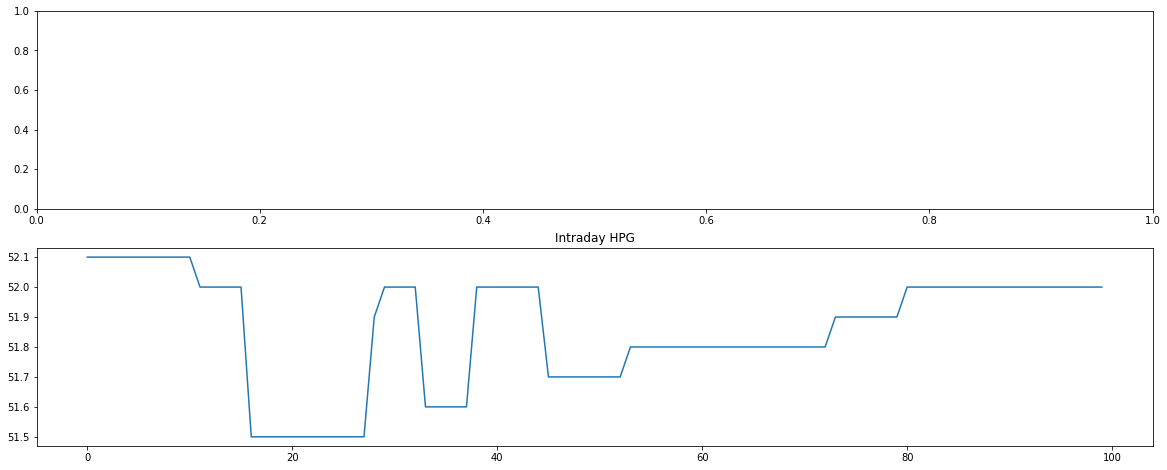

In [ ]:
#PHÂN TÍCH VÀ VẼ ĐỒ THỊ INTRADAY
stock = "hpg"
df = GetIntradayData(stock,0) #Lấy ngày hiện tại
Prices = df["Giá"]
Vols = (df["KL"])
n = 100

fg, ax = plt.subplots(2, 1, figsize=(20, 8))
#fg.suptitle('Images of fish')

#plt.subplot(2,1)
plt.title("Intraday " + stock.upper())
plt.plot(Prices[0:n])
plt.show()
# plt.plot(Vols[0],Prices[0],'r^')
# plt.plot(Vols[1],Prices[1],'y^')
# plt.plot(Vols[2],Prices[2],'b^')
# plt.plot(Vols[1:10],Prices[1:10],"b^")
index = []
for i in range(0,100):
  index.append(i)
  #Đồ thị thứ 2
#plt.subplot(2,2)
#Vols.tail(n).plot.bar()
# df = pd.DataFrame({'x':Vols}, index = 100)
# df.plot.bar()
#plt.bar(index, Vols)
#plt.hist(Vols[0:n],bins = 20)

# plt.plot(Vols[0:50],Prices[0:50],"go")
# plt.plot(Vols[0],Prices[0],'r^')
# plt.plot(Vols[1],Prices[1],'y^')
# plt.plot(Vols[2],Prices[2],'b^')
# plt.plot(Vols[1:10],Prices[1:10],"b^")


# plt.bar(x = Vols[0:], height = Prices[0:],color = 'green')


# # for i in range(len(Vols)): # your number of bars
# #   plt.text(x = Vols[i], #takes your x values as horizontal positioning argument 
# #   y = Prices[i]+1, #takes your y values as vertical positioning argument 
# #   s = Prices[i], # the labels you want to add to the data
# #   size = 9)
plt.show()
#print(df)


# stocks = ["NVL"]
# n=100
# for stock in stocks:  
#   DATA = ImportData(stock)
#   Prices = DATA['DC']
#   price = float(Prices[0])
#   Vols = DATA['KL']/1000
#   plt.title(stock)
  
#   #Đồ thị thứ nhất
#   plt.subplot(1,3,1)
#   plt.plot(Vols[0:n],Prices[0:n],"go")
#   plt.plot(Vols[0],Prices[0],'r^')
#   plt.plot(Vols[1],Prices[1],'y^')
#   plt.plot(Vols[2],Prices[2],'b^')
#   plt.plot(Vols[1:10],Prices[1:10],"b^")

#   #Đồ thị thứ 2
#   plt.subplot(1,3,2)
#   plt.plot(Vols[0:50],Prices[0:50],"go")
#   plt.plot(Vols[0],Prices[0],'r^')
#   plt.plot(Vols[1],Prices[1],'y^')
#   plt.plot(Vols[2],Prices[2],'b^')
#   plt.plot(Vols[1:10],Prices[1:10],"b^")

#   #Đồ thị thứ 3
#   plt.subplot(1,3,3)
#   plt.plot(Vols[0:5],Prices[0:5],"go")
#   plt.plot(Vols[0],Prices[0],'r^')
#   plt.plot(Vols[1],Prices[1],'y^')
#   plt.plot(Vols[2],Prices[2],'b^')
#   #plt.plot(Vols[1:10],Prices[1:10],"b^")

#   plt.show()

In [ ]:
def DetectShark(stock, day, level):  # Phát hiện cá mập qua dữ liệu
  msg = ""
  try:
    df = GetIntradayData(stock,day)
    #print(stock)
    #print(df)
    stick_vols = df['KL']
    #newdf = df[df["KL"] >= np.average(stick_vols)*12]
    newdf = df[df["KL"] >= np.average(stick_vols)*level]
    i = level
    while(newdf.empty):
      #print(stock + " : Chưa có dấu hiệu ở bậc - " + str(i))
      i = i - 1
      newdf = df[df["KL"] >= np.average(stick_vols)*i]
      if(not newdf.empty):
        print("")
        #print(stock + " : Đã có dữ liệu ở bậc - " + str(i))
    if(i>5):
      newdf = df[df["KL"] >= np.average(stick_vols)*(i-5)]
    #print(stock + " - Bậc :" + str(i))
    #print(newdf)
    stick_vols = newdf['KL']
    count = 0
    for stick in stick_vols:
      if(stick >= np.average(stick_vols)):
        count = count + 1
        #print(stick)
    if(not newdf.empty):
      msg = stock + " Bậc: " + str(i-5) + " - " + str(i) + "\n\n" + newdf.to_string()
    return msg
  except:
    msg = stock + ". Vui lòng kiểm tra lại mã cổ phiếu"
    return msg
  #return [stock, i, newdf]
  #print(count)

print(DetectShark("ctg",6,15))

Today is:  2021-06-20
Yesterday was:  2021-06-14
14/6/2021
https://s.cafef.vn/Lich-su-giao-dich-ctg-6.chn?date=14/6/2021

ctg Bậc: 8 - 13

    Thời gian   Giá            Info     KL  KL Tích lũy  Tỷ trọng
216  11:10:45  51.6  +1.10 (+2.18%)  30500       781930  2.31 (%)
370  09:47:47  52.4  +1.90 (+3.76%)  43770       370880  3.31 (%)
371  09:45:16  51.9  +1.40 (+2.77%)  39470       327110  2.99 (%)
372  09:43:13  51.7  +1.20 (+2.38%)  41750       287640  3.16 (%)
373  09:41:00  51.4  +0.90 (+1.78%)  32810       245890  2.48 (%)
376  09:36:03  51.2  +0.70 (+1.39%)  37340       203730  2.83 (%)
377  09:32:10  51.1  +0.60 (+1.19%)  33320       166390  2.52 (%)
378  09:26:55  51.1  +0.60 (+1.19%)  40200       133070  3.04 (%)
379  09:22:51  51.3  +0.80 (+1.58%)  44110        92870  3.34 (%)
387  09:15:50  51.4  +0.90 (+1.78%)  27190        27190  2.06 (%)


In [ ]:
def buildUrl(stock,n):
    url = 'https://www.cophieu68.vn/historyprice.php?currentPage='+str(n) + '&id=' + stock
    return url
 
def buildSoup(url):
   page = urllib.request.urlopen(url)
   soup = BeautifulSoup(page, 'html.parser')
   return soup.encode("utf-8")
   
def ImportData(stock): #Lấy từ chatbot qua
    if(stock == "INDEX"):
        return
    elif (len(stock.strip()) > 3):
        return
    elif (len(stock.strip()) < 3):
        return
    else:
        url = buildUrl(stock, 1)
        response = requests.get(url, verify=False)
        soup = BeautifulSoup(response.text, "html.parser")
        table = soup.findAll('table', {"class": "stock"})
        if(len(table) == 0):
            print("Mã cổ phiếu sai hoặc không lấy được thông tin cổ phiếu")
            return -1
        else:
            try:
                tr = table[0].findAll(['tr'])[1:]
                tablePrices = []
                i = 0
                for cell in tr:
                    th = cell.find_all('th')
                    th_data = [col.text.strip('\n') for col in th]
                    td = cell.find_all('td')
                    row = [i.text.replace('\n', '') for i in td]
                    #print(row[0])
                    if(row[0].startswith('#')):
                      tablePrices.insert(
                          i, [row[5], row[4], row[6], row[11], row[12]])
                      i = i+1
 
                #Thêm vào dữ liệu của phiên gần nhất (do cophieu68 thiếu dữ liệu)
 
                df = pd.DataFrame(
                    tablePrices, columns=['DC', '%', 'KL', 'NN Mua', 'NN Ban'])
 
                df = df.replace(',', '', regex=True)
                #df = df.replace('.', '', regex=True)
                df = df.apply(pd.to_numeric, errors='ignore')
                df['KL'] = df['KL']
                df['NN Mua'] = df['NN Mua']
                df['NN Ban'] = df['NN Ban']
                df["NN"] = df['NN Mua'] - df['NN Ban']
                df["KL(NN)"] = df['NN Mua'] + df['NN Ban']
                df["KL(NN)/KL)"] = (df['NN']/df['KL'])*100
                #print(df)
                return df
            except:
                print("Không lấy được dữ liệu")
                return
                #return None
            #return None
            return

#data = ImportData("HPG")
#print(data)

def GiaoDichNN(price,items):
    _sum = np.sum(items)
    _max = np.max(items)
    #print("_max: " + _max)
    _min = np.min(items)
    #print("Min : " + _min)
    _avg = np.average(items)
    phien_mua = 0
    phien_ban = 0
    KL_Ban = 0
    KL_Mua = 0
    i = 0
    while (i <= 48):
        if(items[i]<0):
            phien_ban = phien_ban + 1
            KL_Ban = KL_Ban + items[i]
        else:
            phien_mua = phien_mua + 1
            KL_Mua = KL_Mua + items[i]
        i = i + 1
    
    trend_mua = 0
    trend_ban = 0
    trend = 0
    #count = 0
    if(items[0] > 0):
        for j in range(0,48):
            if(items[j] > 0):
                trend_mua = trend_mua + 1
            else:
                break
    if(items[0] < 0):
        for j in range(0, 48):
            if(items[j] < 0):
                trend_ban = trend_ban + 1
            else:
                break
 
    if(trend_ban > 0):
        trend="Bán: " + str(trend_ban)
    if(trend_mua > 0):
        trend = "Mua: " + str(trend_mua)
    output = ""
 
    output = output + "Số phiên mua vào: " + \
        str(phien_mua) + " | KL (Mua): " + str('{:,.2f}'.format(KL_Mua))
 
    output = output + "\n" + "Số phiên bán ra: " + str(phien_ban) +\
          " | KL (Ban): " + str('{:,.2f}'.format(KL_Ban))
    _n = np.max([trend_ban, trend_mua]) 
    tong_KL_trend = np.sum(items[0:_n])    
    output = output + "\n" + "Xu hướng: " + str(trend) + \
        " | Tổng KL (trend): " + str('{:,.2f}'.format(tong_KL_trend)) +\
            " ~ " + str('{:,.2f}'.format(tong_KL_trend*price/1000000) + " (tỷ)")
    output = output + "\n" + "Tổng: " + str('{:,.2f}'.format(_sum)) + " |Max: " + str('{:,.2f}'.format(_max)) +\
        " |Min: " + str('{:,.2f}'.format(_min)) + \
        " |TB: " + str('{:,.2f}'.format(_avg))
    return output
 
 
def Analysis(stock, n):  # n - số phiên  
  DATA = ImportData(stock)  
  Prices = DATA['DC']
  price = float(Prices[0])
  Vols = DATA['KL']
  vol = float(Vols[0])
  NN_Mua = DATA['NN Mua']
  NN_Ban = DATA['NN Ban']
  NN = DATA['NN'] #Mua - Ban  
  money = float(Prices[0]*Vols[0]/1000000)  # Tỷ
  
  results = []
 
  data = GetDetail(stock)
  #print(data) #'CTG', 40.5, 16047000.0, 2.4, 39.6, 17.0, 41.45, 40.2, 'CTG : 40.5 : 2.4 (%) - 41.45 
  # [stock, price, vol, margin, max_52_tuan, min_52_tuan, max_in_day, min_in_day, info_now]
  max_52 = float(data[4])  
  min_52 = float(data[5])
  max = float(data[6])  
  min = float(data[7])  
 
  margin_prices = []
  margin_vols=[]
  PocketPivots = []
  for i in range(0, len(Prices)-1):
    margin = float(percent(Prices[i], Prices[i+1]))
    margin_vol = float(percent(Vols[i], Vols[i+1]))
    margin_prices.append(margin)
    if(margin >= 4) and (margin_vol >= 1):
      PocketPivots.append([margin,i,Prices[i],Prices[i+1]])
 
  margin_price_max = float(np.max(margin_prices))
  margin_price_min = float(np.min(margin_prices))
 
  msg = stock + ' | ' + str(Prices[0]) + ' | ' + str('{:,.2f}'.format(margin_prices[0])) + \
      ' (%)| ' + str('{:,.2f}'.format(money)) + ' (tỷ)'
  
  if(price >= max_52):
    msg = msg + " [Vượt " + str('{:,.2f}'.format(percent(price, max_52))) +\
        " (%) đỉnh 52 tuần] - Tăng/Giảm cao nhất: [" + str('{:,.2f}'.format(margin_price_max)) + " | " +\
             str('{:,.2f}'.format(margin_price_min)) + " (%)]"
  else:
    msg = msg + " [Đạt " + str('{:,.2f}'.format((percent(price, max_52)))) + " (%) đỉnh 52 tuần] - Tăng/Giảm cao nhất: [" +\
        str('{:,.2f}'.format(margin_price_max)) + " | " + str('{:,.2f}'.format(margin_price_min)) + " (%)]"
  
  #Điểm pviot
  txt = ""
  if(len(PocketPivots) <=0):
      print(stock + " : Không có điểm pivots")
      msg = msg + "\nĐiểm pivots: 49 phiên chưa thấy pivots"
  else:
    for p in PocketPivots:  # [margin,i,Prices[i],Prices[i+1]]
        _bien_dong_gia = str('{:,.2f}'.format(percent(price, p[3])))
        txt = txt + "\n" + str(p[3]) + " -> " + str(p[2]) + " : " + str('{:,.2f}'.format(p[0])) + " (%) - Cách đây: " +\
            str(p[1]) + " (phiên) " + " & Hiện tại: " + _bien_dong_gia + " (%)"
    msg = msg + "\nĐiểm pivots: \n" + txt[1:]
  #Phân tích TREND
  trend = ""
  trend = trend + "\n" + "Diễn biến 03 phiên : \n" + \
      "Giá: " +\
      str('{:.2f}'.format(margin_prices[0] + margin_prices[1] + margin_prices[2])) + " (%) | " +\
      str('{:.2f}'.format(margin_prices[0])) + " | " +\
            str('{:.2f}'.format(margin_prices[1])) + " | " +\
            str('{:.2f}'.format(margin_prices[2])) +\
      "\nKhối ngoại: " +\
      str('{:,.2f}'.format(NN[0] + NN[1] + NN[2])) + " | " +\
      str('{:,.2f}'.format(NN[0])) + " | " +\
      str('{:,.2f}'.format(NN[1])) + " | " +\
      str('{:,.2f}'.format(NN[2]))
 
  #for i in range(0,n):
 
  if((margin_prices[0] < 0) and (margin_prices[1] < 0) and (margin_prices[2] < 0)):
    trend = trend + " - Đang trend giảm"
  if((margin_prices[0] > 0) and (margin_prices[1] > 0) and (margin_prices[2] > 0)):
    trend = trend + " - Đang trend tăng"
 
  msg = msg + trend
 
  #Phân tích khối lượng
  vol0 = float(Vols[0])
  vol1 = float(Vols[1])
  vol_avg = float(np.average(Vols[1:n]))
  vol_max = float(np.max(Vols[1:n]))
  vol_min = float(np.min(Vols[1:n]))
  
  
  if(vol1 >0) and (vol_avg > 0):
    margin_vol = float(percent(Vols[0], Vols[1]))
    rate_vol_max = float(Vols[0]/vol_max)
    rate_vol_min = float(Vols[0]/vol_min)
    rate_vol_avg = float(Vols[0]/vol_avg)
    if (vol0/vol1 >= 1.5) or (vol0/vol_avg >= 1.5):    
      msg = msg + ' \nKhối lượng: Vượt TB ' + str(n) + ' phiên'
    if (rate_vol_max >= 1):
      msg = msg + ' \nKhối lượng: Vượt đỉnh KL. Đạt ' + \
          str('{:,.2f}'.format(rate_vol_max)) + " " + str(n) + ' phiên'
    if (vol0 <= vol_min):
      msg = msg + ' \nChú ý: Cạn khối lượng ' + str(n) + ' phiên'
    else:
      msg = msg + ' \nKhối lượng đạt ' + \
          str('{:,.2f}'.format(rate_vol_avg)) + \
          " (lần) của TB " + str(n) + ' phiên'
      
    #Diễn biến khối ngoại
    str_NN = GiaoDichNN(price, NN)
    NN_Max = float(np.max(NN))
    NN_Min = float(np.min(NN))
    NN_Avg = float(np.average(NN))
    NN_T0 = float(NN[0])
    msg_nn = "" #Ghi chú để phân tích diễn biến khối ngoại
    if(NN_T0 >= NN_Max):
      msg_nn = msg_nn + \
          ' [TỐT] Nước ngoài mua đột biến, cao nhất trong ' + str(n) + ' phiên.'
    elif (NN_T0 <= NN_Min):
      msg_nn = msg_nn + ' [XẤU] Nước ngoài đang bán ra rất mạnh ' + \
          str(n) + ' phiên.'
    msg = msg + "\nDỮ LIỆU KHỐI NGOẠI\n" + msg_nn + "\n" + str_NN
  
    if(price == max):
      msg = msg + " - [+] Khớp lệnh ở giá cao nhất trong ngày"
      if(margin_prices[0] >= 3):
          msg = msg + "==> Lưu ý: Đặc biệt mạnh"
    elif(price == min):
      msg = msg + " - [-] Khớp lệnh ở giá thấp nhất trong ngày"
      if(margin_prices[0] <= -3):
          msg = msg + "==> Lưu ý: Cổ phiếu có đấu hiệu yếu, bạn cần đánh giá lại thêm."
  
    results.append(stock) #Cổ phiếu
    results.append(price) #Giá
    results.append(vol) #Khối lượng
    results.append(margin_prices[0]) #Tăng/Giảm so với phiên trước
    results.append(max_52)
    results.append(min_52)
    results.append(max)
    results.append(min)
    results.append(vol_avg)
    results.append(vol_max)
    results.append(vol_min)
    results.append(margin_vol) #Tăng/giảm so với ngày hôm qua
    results.append(rate_vol_max) #Tỷ lệ so với vol_max
    results.append(rate_vol_min) #Tỷ lệ so với vol_min
    results.append(rate_vol_avg) #Tỷ lệ so với vol_Tb
    results.append(NN_Mua[0]) #Tỷ lệ so với vol_Tb
    results.append(NN_Ban[0]) #Tỷ lệ so với vol_Tb
  
    #print(results)
    #df = pd.DataFrame(results,columns=['Cổ phiếu', 'Giá', 'Khối lượng', 'Giá (+/-)', 'Max(52)','Min(52)', 'Max(Day)', 'Min(Day)', 'Vol_TB', 'Vol_Max','Vol_Min'])
    #df = df.replace(',', '', regex=True)
    #df = df.apply(pd.to_numeric, errors='ignore')
    #print(df)
 
  return results #[margin_prices, msg, NN]
 
def Analysis_Stock_2(stock):
  return Analysis(stock,49)
 
print(Analysis_Stock_2("HPG"))
print(Analysis_Stock_2("VPS"))
 

['HPG', 52.1, 28992700.0, 1.3618677042801612, 55.5, 15.6, 53.3, 51.4, 28718237.5, 60309100.0, 11970000.0, 43.415331496495334, 0.48073507978066327, 2.4221136173767754, 1.009557080235164, 0, 0]
['VPS', 16.2, 4100.0, 1.2499999999999956, 21.6, 8.0, 16.2, 16.0, 49658.333333333336, 157800.0, 5300.0, -72.84768211920529, 0.025982256020278833, 0.7735849056603774, 0.08256418862225205, 0, 200]


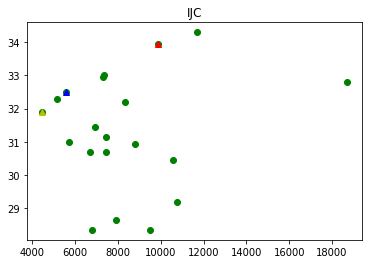

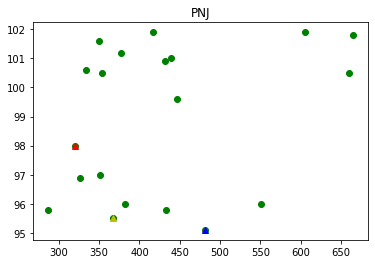

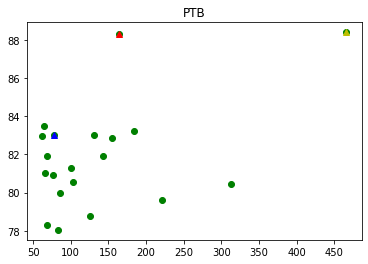

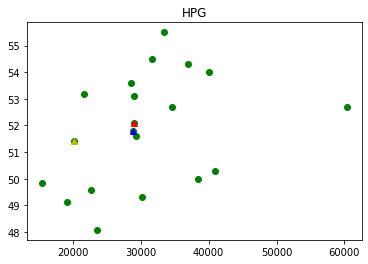

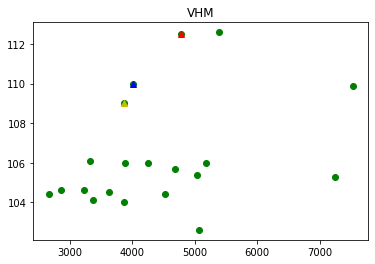

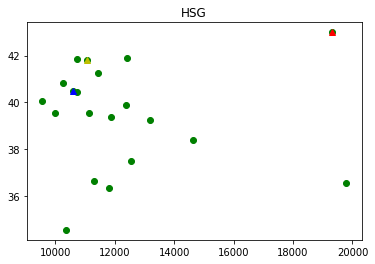

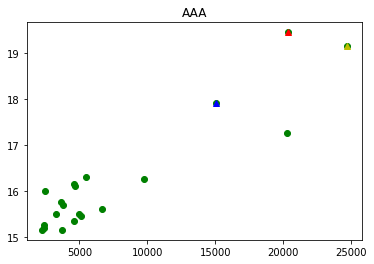

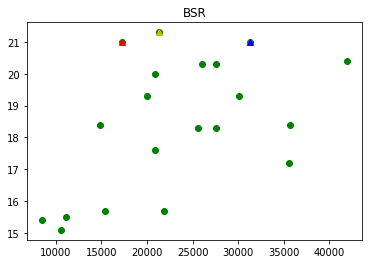

In [ ]:
stocks = ["IJC","PNJ","PTB","HPG","VHM","HSG","AAA","BSR"]
n=20
for stock in stocks:  
  DATA = ImportData(stock)
  Prices = DATA['DC']
  price = float(Prices[0])
  Vols = DATA['KL']/1000
  plt.title(stock)
  plt.plot(Vols[0:n],Prices[0:n],"go")
  plt.plot(Vols[0],Prices[0],'r^')
  plt.plot(Vols[1],Prices[1],'y^')
  plt.plot(Vols[2],Prices[2],'b^')
  plt.show()

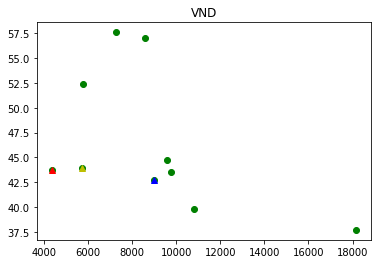

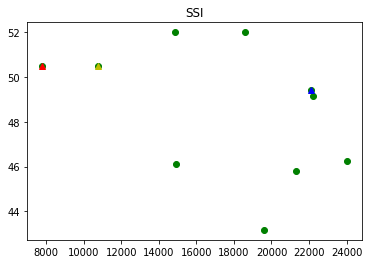

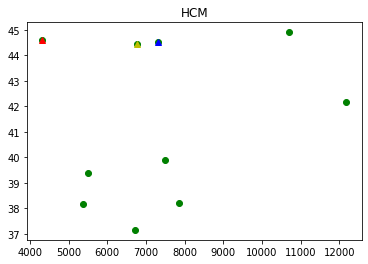

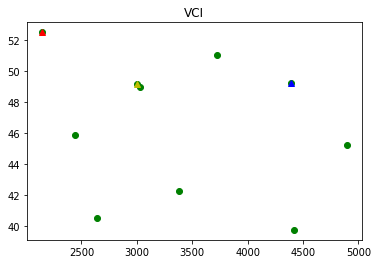

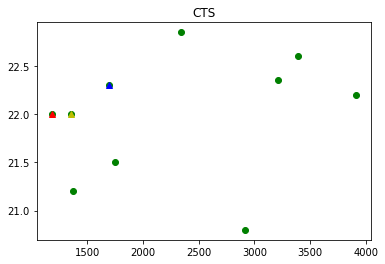

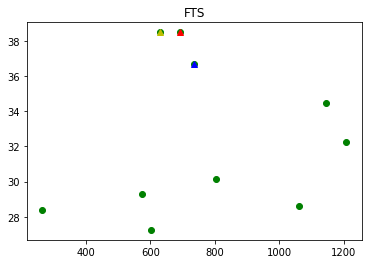

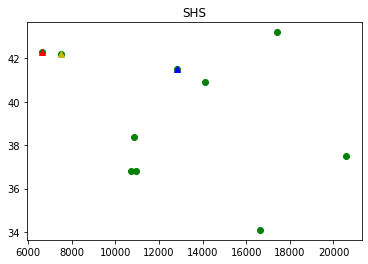

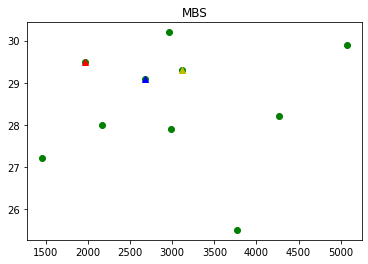

In [ ]:
stocks = ["VND","SSI","HCM","VCI","CTS","FTS","SHS","MBS"]
n=10
for stock in stocks:  
  DATA = ImportData(stock)
  Prices = DATA['DC']
  price = float(Prices[0])
  Vols = DATA['KL']/1000
  plt.title(stock)
  plt.plot(Vols[0:n],Prices[0:n],"go")
  plt.plot(Vols[0],Prices[0],'r^')
  plt.plot(Vols[1],Prices[1],'y^')
  plt.plot(Vols[2],Prices[2],'b^')
  plt.show()

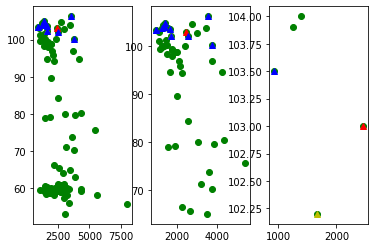

In [ ]:
stocks = ["NVL"]
n=100
for stock in stocks:  
  DATA = ImportData(stock)
  Prices = DATA['DC']
  price = float(Prices[0])
  Vols = DATA['KL']/1000
  plt.title(stock)
  
  #Đồ thị thứ nhất
  plt.subplot(1,3,1)
  plt.plot(Vols[0:n],Prices[0:n],"go")
  plt.plot(Vols[0],Prices[0],'r^')
  plt.plot(Vols[1],Prices[1],'y^')
  plt.plot(Vols[2],Prices[2],'b^')
  plt.plot(Vols[1:10],Prices[1:10],"b^")

  #Đồ thị thứ 2
  plt.subplot(1,3,2)
  plt.plot(Vols[0:50],Prices[0:50],"go")
  plt.plot(Vols[0],Prices[0],'r^')
  plt.plot(Vols[1],Prices[1],'y^')
  plt.plot(Vols[2],Prices[2],'b^')
  plt.plot(Vols[1:10],Prices[1:10],"b^")

  #Đồ thị thứ 3
  plt.subplot(1,3,3)
  plt.plot(Vols[0:5],Prices[0:5],"go")
  plt.plot(Vols[0],Prices[0],'r^')
  plt.plot(Vols[1],Prices[1],'y^')
  plt.plot(Vols[2],Prices[2],'b^')
  #plt.plot(Vols[1:10],Prices[1:10],"b^")

  plt.show()

In [ ]:
import time
import pandas as pd
def CrawlTodayData_All_Stocks():
  stocks = Get_All_Stocks()  
  results = []
  errors = []
  i = 1
  for stock in stocks:
    print('Đang chạy: ' + stock + " | " + str(i) + "/" + str(len(stocks)))
    try:
      rs = Analysis_Stock_2(stock)      
      time.sleep(0.5)
      results.append(rs)
    except:
      print("Lỗi : " + stock)
      errors.append(stock)
    i = i + 1
  
  df = pd.DataFrame(results,columns=['Cổ phiếu', 'Giá', 'Khối lượng', 'Giá (+/-)', 'Max(52)','Min(52)', 'Max(Day)', 'Min(Day)', 'Vol_TB', 'Vol_Max','Vol_Min', 'Vol(+/-)', 'Vol&Max', 'Vol&Min','Vol&Avg','NN(Mua)','NN(Ban)'])
  
  return df

df = CrawlTodayData_All_Stocks()

['VNE' 'VNG' 'VNM' 'VPB' 'VPG' 'VPI' 'VPS' 'VRC' 'VRE' 'VSC' 'VGC' 'VHC'
 'VHM' 'VIB' 'VIC' 'VIP' 'VJC' 'VND' 'TTA' 'TTB' 'TV2' 'TVB' 'TVS' 'TYA'
 'UDC' 'VCB' 'VCI' 'VDS' 'TDM' 'TDP' 'TEG' 'THG' 'TIP' 'TLD' 'TLG' 'TLH'
 'TMS' 'TNA' 'TPB' 'SRC' 'SSI' 'STB' 'STG' 'STK' 'SZC' 'SZL' 'TAC' 'TBC'
 'TCB' 'TCD' 'TCH' 'TCL' 'TCM' 'TCT' 'TDC' 'TDH' 'SCR' 'SCS' 'SFG' 'SFI'
 'SGR' 'SGT' 'SHI' 'SJD' 'SJS' 'SKG' 'SMC' 'PNJ' 'POM' 'POW' 'PPC' 'PSH'
 'PVT' 'PXS' 'QCG' 'RAL' 'REE' 'SAB' 'SAM' 'SAV' 'SBA' 'SBT' 'SBV' 'MHC'
 'MSB' 'MSH' 'MSN' 'MWG' 'NAF' 'NCT' 'NHH' 'NKG' 'NLG' 'NNC' 'NT2' 'NTL'
 'NVL' 'OGC' 'PAC' 'PAN' 'PC1' 'PDR' 'PET' 'PGC' 'PHC' 'PHR' 'PLP' 'PLX'
 'PMG' 'KPF' 'KSB' 'LCG' 'LDG' 'LHG' 'LIX' 'LPB' 'LSS' 'MBB' 'HSG' 'HT1'
 'HTI' 'HTN' 'HVH' 'HVN' 'IBC' 'ICT' 'IDI' 'IJC' 'ILB' 'IMP' 'ITA' 'ITC'
 'ITD' 'KBC' 'KDC' 'KDH' 'KHP' 'KOS' 'DVP' 'DXG' 'EIB' 'ELC' 'EVG' 'FCN'
 'FIR' 'FIT' 'FLC' 'FMC' 'FPT' 'FRT' 'FTS' 'GAS' 'GDT' 'GEG' 'GEX' 'GIL'
 'GMC' 'GMD' 'GTN' 'GVR' 'HAH' 'HAP' 'HAX' 'HBC' 'H

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


Đang chạy: TTA | 19/405
Đang chạy: TTB | 20/405
Đang chạy: TV2 | 21/405
Đang chạy: TVB | 22/405


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: RuntimeWarning: divide by zero encountered in true_divide


Đang chạy: TVS | 23/405
Đang chạy: TYA | 24/405
Đang chạy: UDC | 25/405
Đang chạy: VCB | 26/405
Đang chạy: VCI | 27/405
Đang chạy: VDS | 28/405
Đang chạy: TDM | 29/405
Đang chạy: TDP | 30/405
Đang chạy: TEG | 31/405
Đang chạy: THG | 32/405
Đang chạy: TIP | 33/405
Đang chạy: TLD | 34/405
Đang chạy: TLG | 35/405
Đang chạy: TLH | 36/405
Đang chạy: TMS | 37/405
Đang chạy: TNA | 38/405
Đang chạy: TPB | 39/405
Đang chạy: SRC | 40/405
Đang chạy: SSI | 41/405
Đang chạy: STB | 42/405
Đang chạy: STG | 43/405
Đang chạy: STK | 44/405
Đang chạy: SZC | 45/405
Đang chạy: SZL | 46/405
Đang chạy: TAC | 47/405
Đang chạy: TBC | 48/405
Đang chạy: TCB | 49/405
Đang chạy: TCD | 50/405
Đang chạy: TCH | 51/405
Đang chạy: TCL | 52/405
Đang chạy: TCM | 53/405
Đang chạy: TCT | 54/405
Đang chạy: TDC | 55/405
Đang chạy: TDH | 56/405
Đang chạy: SCR | 57/405
Đang chạy: SCS | 58/405
Đang chạy: SFG | 59/405
Đang chạy: SFI | 60/405
Đang chạy: SGR | 61/405
Đang chạy: SGT | 62/405
Đang chạy: SHI | 63/405
Đang chạy: SJD |

In [ ]:
df = df.replace(',', '', regex=True)
df = df.apply(pd.to_numeric, errors='ignore')
pd.options.display.float_format = '{:,.2f}'.format
df.to_excel("Stocks-Live-" + str(datetime.date.today()) + ".xlsx")
print("Đã xuất dữ liệu thô")
#1. Danh sách các cổ phiếu vượt đỉnh 52 tuần.
df1 = df
df1 = df1[df1['Giá'] >= df1['Max(52)']]
df1.to_excel("Stocks-Live-" + str(datetime.date.today()) + "-Max52.xlsx")
#df = df[df['Vol_Min'] >= 1000]

# def Make_Daily_Report():
#   #df = CrawlTodayData_All_Stocks()
#   #0. Xuất toàn bộ dữ liệu thô
#   # df = df[df['Giá'] >= 7]
#   # df = df[df['Vol_Min'] >= 1000]

#   df = df.replace(',', '', regex=True)
#   df = df.apply(pd.to_numeric, errors='ignore')
#   pd.options.display.float_format = '{:,.2f}'.format
#   df.to_excel("Stocks-Live-" + str(datetime.date.today()) + ".xlsx")
#   print("Đã xuất dữ liệu thô")
#   #1. Danh sách các cổ phiếu vượt đỉnh 52 tuần.
#   df1 = df
#   df1 = df1[df1['Giá'] >= df1['Max52']]
#   df1.to_excel("Stocks-Live-" + str(datetime.date.today()) + "-Max52.xlsx")
#   #df = df[df['Vol_Min'] >= 1000]

# Make_Daily_Report()

NameError: ignored

In [ ]:
#!pip install openpyxl
import time
import pandas as pd
import datetime
import numpy as np


def Read_All_Data_Market():
  _df = pd.read_excel("Stocks-Live-" + str(datetime.date.today()) + ".xlsx", sheet_name="Sheet1")
  print(_df)

Read_All_Data_Market()

In [ ]:
# wp = Client('https://alphacodeclub.wordpress.com/xmlrpc.php','taipm.bidv@gmail.com', 'P@$$w0rdPMT')
 
# def Get(searchKey):
#     results = []
#     posts = wp.call(GetPosts())
#     for post in posts:
#         if(searchKey in post.title):
#             results.append(post)
#             print(post.title)
#     print(results)
#     #print(len(results))
#     return results
 
# #Get("Notes")

# def Create_All_Stock_Today():
#     title = "[Data] | " + str(datetime.date.today())
#     post = WordPressPost()
#     post.title = title    
#     content = CrawlTodayData_All_Stocks().to_html()
#     post.content = content
 
#     post.terms_names = {
#         'post_tag': [title, 'Chứng khoán', 'Dữ liệu', 'Cá mập', 'Shark', 'VN30'],
#         'category': ['Dữ liệu', 'Chứng khoán']
#     }
#     post.post_status = 'publish'
#     wp.call(NewPost(post))
 
# def Update_All_Stock_Today():
#   title = "[Data] | " + str(datetime.date.today())
#   posts = Get(title)
#   post = posts[0]
#   print(post.title)
#   content = CrawlTodayData_All_Stocks().to_html()
#   post.content = content
#   print("Update VN30")
#   print(content)
#   post.terms_names = {
#                 'post_tag': [title, 'Chứng khoán', 'Dữ liệu', 'Shark', 'VN30'],
#                 'category': ['Dữ liệu', 'Chứng khoán']
#             }
#   post.post_status = 'publish'
#   wp.call(EditPost(post.id, post))
 
# def Post_All_Stock_Today():
#     title = "[Data] | " + str(datetime.date.today())
#     posts = Get(title)
#     print(len(posts))
#     if(len(posts) == 0):
#       print("Đang tạo mới")
#       Create_All_Stock_Today()
#     else:
#       print("Đang update")
#       Update_All_Stock_Today()

# Post_All_Stock_Today()

Đang chạy: LDG | 113/405
Lỗi : LDG
Đang chạy: LHG | 114/405


In [ ]:
# import time
# def CrawlTodayData_All_Stocks():
#   stocks = Get_All_Stocks()
  
#   results = []

#   for stock in stocks[0:3]:
#     rs = getDetail(stock)
#     time.sleep(1)
#     results.append(rs[0:len(rs)-1])
  
#   df = pd.DataFrame(results,columns=['Cổ phiếu', 'Giá', 'Khối lượng', 'Giá (+/-)', 'Max(52)','Min(52)', 'Max(Day)', 'Min(Day)'])
#   df = df.replace(',', '', regex=True)
#   df = df.apply(pd.to_numeric, errors='ignore')
#   print(df)

# CrawlTodayData_All_Stocks()

In [ ]:
# from bs4.element import ProcessingInstruction
 
# def ImportData(stock): #Lấy từ chatbot qua
#     if(stock == "INDEX"):
#         return
#     elif (len(stock.strip()) > 3):
#         return
#     elif (len(stock.strip()) < 3):
#         return
#     else:
#         url = buildUrl(stock, 1)
#         response = requests.get(url, verify=False)
#         soup = BeautifulSoup(response.text, "html.parser")
#         table = soup.findAll('table', {"class": "stock"})
#         if(len(table) == 0):
#             print("Mã cổ phiếu sai hoặc không lấy được thông tin cổ phiếu")
#             return -1
#         else:
#             try:
#                 tr = table[0].findAll(['tr'])[1:]
#                 tablePrices = []
#                 i = 0
#                 for cell in tr:
#                     th = cell.find_all('th')
#                     th_data = [col.text.strip('\n') for col in th]
#                     td = cell.find_all('td')
#                     row = [i.text.replace('\n', '') for i in td]
#                     tablePrices.insert(
#                         i, [row[5], row[4], row[6], row[11], row[12]])
#                     i = i+1
 
#                 #Thêm vào dữ liệu của phiên gần nhất (do cophieu68 thiếu dữ liệu)
 
#                 df = pd.DataFrame(
#                     tablePrices, columns=['DC', '%', 'KL', 'NN Mua', 'NN Ban'])
 
#                 df = df.replace(',', '', regex=True)
#                 #df = df.replace('.', '', regex=True)
#                 df = df.apply(pd.to_numeric, errors='ignore')
#                 df['KL'] = df['KL']
#                 df['NN Mua'] = df['NN Mua']
#                 df['NN Ban'] = df['NN Ban']
#                 df["NN"] = df['NN Mua'] - df['NN Ban']
#                 df["KL(NN)"] = df['NN Mua'] + df['NN Ban']
#                 df["KL(NN)/KL)"] = (df['NN']/df['KL'])*100
#                 #print(df)
#                 return df
#             except:
#                 print("Không lấy được dữ liệu")
#                 return
#                 #return None
#             #return None
#             return
 
 
# #print(getDetail("CTG"))
# def GiaoDichNN(price,items):
#     _sum = np.sum(items)
#     _max = np.max(items)
#     #print("_max: " + _max)
#     _min = np.min(items)
#     #print("Min : " + _min)
#     _avg = np.average(items)
#     phien_mua = 0
#     phien_ban = 0
#     KL_Ban = 0
#     KL_Mua = 0
#     i = 0
#     while (i <= 48):
#         if(items[i]<0):
#             phien_ban = phien_ban + 1
#             KL_Ban = KL_Ban + items[i]
#         else:
#             phien_mua = phien_mua + 1
#             KL_Mua = KL_Mua + items[i]
#         i = i + 1
    
#     trend_mua = 0
#     trend_ban = 0
#     trend = 0
#     #count = 0
#     if(items[0] > 0):
#         for j in range(0,48):
#             if(items[j] > 0):
#                 trend_mua = trend_mua + 1
#             else:
#                 break
#     if(items[0] < 0):
#         for j in range(0, 48):
#             if(items[j] < 0):
#                 trend_ban = trend_ban + 1
#             else:
#                 break
 
#     if(trend_ban > 0):
#         trend="Bán: " + str(trend_ban)
#     if(trend_mua > 0):
#         trend = "Mua: " + str(trend_mua)
    
#     # j = i
#     # while(j)
#     output = ""
 
#     #print("So phien mua vào: " + str(phien_mua) + " | KL (Mua): " + str('{:,.2f}'.format(KL_Mua)))
#     output = output + "Số phiên mua vào: " + \
#         str(phien_mua) + " | KL (Mua): " + str('{:,.2f}'.format(KL_Mua))
 
#     #print("So phien bán ra: " + str(phien_ban) +
#     #      " | KL (Ban): " + str('{:,.2f}'.format(KL_Ban)))
#     output = output + "\n" + "Số phiên bán ra: " + str(phien_ban) +\
#           " | KL (Ban): " + str('{:,.2f}'.format(KL_Ban))
 
#     #print("Trend : " + trend)
#     _n = np.max([trend_ban, trend_mua])
#     #print("Số phiên của trend: " + str(_n))
#     tong_KL_trend = np.sum(items[0:_n])
#     #print(str(tong_KL_trend) + " : " +str(_n))
#     output = output + "\n" + "Xu hướng: " + str(trend) + \
#         " | Tổng KL (trend): " + str('{:,.2f}'.format(tong_KL_trend)) +\
#             " ~ " + str('{:,.2f}'.format(tong_KL_trend*price/1000000) + " (tỷ)")
#     #print("Tong: " + str('{:,.2f}'.format(_sum)) + " |Max: " + str('{:,.2f}'.format(_max)) +\
#     #     " |Min: " + str('{:,.2f}'.format(_min)) + " |TB: " + str('{:,.2f}'.format(_avg)))
#     output = output + "\n" + "Tổng: " + str('{:,.2f}'.format(_sum)) + " |Max: " + str('{:,.2f}'.format(_max)) +\
#         " |Min: " + str('{:,.2f}'.format(_min)) + \
#         " |TB: " + str('{:,.2f}'.format(_avg))
#     #print("Output: " + output)
#     #for item in items:
#     return output
 
 
# def analysis(stock, n):  # n - số phiên
#   print(stock)
#   DATA = ImportData(stock)
#   #print(DATA)
#   Prices = DATA['DC']
#   price = float(Prices[0])
#   Vols = DATA['KL']
#   #NN_Mua = DATA['NN Mua']
#   #NN_Ban = DATA['NN Ban']
#   NN = DATA['NN'] #Mua - Ban
#   #NN_TyTrong = DATA["KL(NN)/KL)"]
 
#   #PHIÊN HIỆN TẠI
#   money = float(Prices[0]*Vols[0]/1000000)  # Tỷ
#   #print("Tiền: " + str(money))
 
#   data = getDetail(stock)
#   #print("getDetail: ")
#   #print(data)
#   max_52 = float(data[4])
#   min_52 = float(data[5])
#   max = float(data[6])
#   min = float(data[7])
 
#   margin_prices = []
#   margin_vols=[]
#   PocketPivots = []
#   for i in range(0, len(Prices)-1):
#     margin = float(percent(Prices[i], Prices[i+1]))
#     margin_vol = float(percent(Vols[i], Vols[i+1]))
#     margin_prices.append(margin)
#     if(margin >= 4) and (margin_vol >= 1):
#       PocketPivots.append([margin,i,Prices[i],Prices[i+1]])
 
#   margin_price_max = float(np.max(margin_prices))
#   margin_price_min = float(np.min(margin_prices))
 
#   msg = stock + ' | ' + str(Prices[0]) + ' | ' + str('{:,.2f}'.format(margin_prices[0])) + \
#       ' (%)| ' + str('{:,.2f}'.format(money)) + ' (tỷ)'
  
#   if(price >= max_52):
#     msg = msg + " [Vượt " + str('{:,.2f}'.format(percent(price, max_52))) +\
#         " (%) đỉnh 52 tuần] - Tăng/Giảm cao nhất: [" + str('{:,.2f}'.format(margin_price_max)) + " | " +\
#              str('{:,.2f}'.format(margin_price_min)) + " (%)]"
#   else:
#     msg = msg + " [Đạt " + str('{:,.2f}'.format((percent(price, max_52)))) + " (%) đỉnh 52 tuần] - Tăng/Giảm cao nhất: [" +\
#         str('{:,.2f}'.format(margin_price_max)) + " | " + str('{:,.2f}'.format(margin_price_min)) + " (%)]"
 
#   #Điểm pviot
#   txt = ""
#   if(len(PocketPivots) <=0):
#       print("Không có điểm pivots")
#       msg = msg + "\nĐiểm pivots: 49 phiên chưa thấy pivots"
#   else:
#     for p in PocketPivots:  # [margin,i,Prices[i],Prices[i+1]]
#         _bien_dong_gia = str('{:,.2f}'.format(percent(price, p[3])))
#         txt = txt + "\n" + str(p[3]) + " -> " + str(p[2]) + " : " + str('{:,.2f}'.format(p[0])) + " (%) - Cách đây: " +\
#             str(p[1]) + " (phiên) " + " & Hiện tại: " + _bien_dong_gia + " (%)"
#     msg = msg + "\nĐiểm pivots: \n" + txt[1:]
#   #Phân tích TREND
#   trend = ""
#   trend = trend + "\n" + "Diễn biến 03 phiên : \n" + \
#       "Giá: " +\
#       str('{:.2f}'.format(margin_prices[0] + margin_prices[1] + margin_prices[2])) + " (%) | " +\
#       str('{:.2f}'.format(margin_prices[0])) + " | " +\
#             str('{:.2f}'.format(margin_prices[1])) + " | " +\
#             str('{:.2f}'.format(margin_prices[2])) +\
#       "\nKhối ngoại: " +\
#       str('{:,.2f}'.format(NN[0] + NN[1] + NN[2])) + " | " +\
#       str('{:,.2f}'.format(NN[0])) + " | " +\
#       str('{:,.2f}'.format(NN[1])) + " | " +\
#       str('{:,.2f}'.format(NN[2]))
 
#   #for i in range(0,n):
 
#   if((margin_prices[0] < 0) and (margin_prices[1] < 0) and (margin_prices[2] < 0)):
#     trend = trend + " - Đang trend giảm"
#   if((margin_prices[0] > 0) and (margin_prices[1] > 0) and (margin_prices[2] > 0)):
#     trend = trend + " - Đang trend tăng"
 
#   msg = msg + trend
#   #Phân tích khối lượng
#   vol0 = float(Vols[0])
#   vol1 = float(Vols[1])
#   vol_avg = float(np.average(Vols[1:n]))
#   vol_max = float(np.max(Vols[1:n]))
#   vol_min = float(np.min(Vols[1:n]))
#   margin_vol = float(percent(Vols[0], Vols[1]))
#   rate_vol_max = float(Vols[0]/np.max(Vols[1:n]))
#   rate_vol_avg = float(Vols[0]/np.average(Vols[1:n]))
 
#   if (vol0/vol1 >= 1.5) or (vol0/vol_avg >= 1.5):
#     msg = msg + ' \nKhối lượng: Vượt TB ' + str(n) + ' phiên'
#   if (rate_vol_max >= 1):
#     msg = msg + ' \nKhối lượng: Vượt đỉnh KL. Đạt ' + \
#         str('{:,.2f}'.format(rate_vol_max)) + " " + str(n) + ' phiên'
#   if (vol0 <= vol_min):
#     msg = msg + ' \nChú ý: Cạn khối lượng ' + str(n) + ' phiên'
#   else:
#     msg = msg + ' \nKhối lượng đạt ' + \
#         str('{:,.2f}'.format(rate_vol_avg)) + \
#         " (lần) của TB " + str(n) + ' phiên'
  
#   #Diễn biến khối ngoại
#   str_NN = GiaoDichNN(price, NN)
#   NN_Max = float(np.max(NN))
#   NN_Min = float(np.min(NN))
#   NN_Avg = float(np.average(NN))
#   NN_T0 = float(NN[0])
#   msg_nn = "" #Ghi chú để phân tích diễn biến khối ngoại
#   if(NN_T0 >= NN_Max):
#     msg_nn = msg_nn + \
#         ' [TỐT] Nước ngoài mua đột biến, cao nhất trong ' + str(n) + ' phiên.'
#   elif (NN_T0 <= NN_Min):
#     msg_nn = msg_nn + ' [XẤU] Nước ngoài đang bán ra rất mạnh ' + \
#         str(n) + ' phiên.'
#   msg = msg + "\nDỮ LIỆU KHỐI NGOẠI\n" + msg_nn + "\n" + str_NN
 
#   if(price == max):
#     msg = msg + " - [+] Khớp lệnh ở giá cao nhất trong ngày"
#     if(margin_prices[0] >= 3):
#         msg = msg + "==> Lưu ý: Đặc biệt mạnh"
#   elif(price == min):
#     msg = msg + " - [-] Khớp lệnh ở giá thấp nhất trong ngày"
#     if(margin_prices[0] <= -3):
#         msg = msg + "==> Lưu ý: Cổ phiếu có đấu hiệu yếu, bạn cần đánh giá lại thêm."
 
#   return msg #[margin_prices, msg, NN]
 
# def Analysis_Stock(stock):
#   return analysis(stock,49)
 
# #print(Analysis_Stock("CTG"))

In [ ]:

# import time
# def Get_Max_52(stocks): #Chạm đỉnh 52 tuần
#   rs = []
#   for stock in stocks:
#     info = getDetail(stock)
#     time.sleep(2.4)
#     try:
#       if(info[1] >= 8) and (info[2] >= 50000) and (info[3] >= 1) and (info[1] >= info[4]):
#         print("Vượt đỉnh")
#         rs.append(' '.join([str(elem) for elem in info]))
#         print(' '.join([str(elem) for elem in info]))
#     except:
#       print(stock + " - Lỗi")
#   #print(rs)
#   return rs
#   #print(stocks)
# #Get_Max_52()

In [ ]:
# import time
# from typing import Set
# import schedule
# import requests
# import telegram


# chat_id = "1133501778"
# token = "1408339597:AAEd1i444kfJa2gv1FprwirR6wTkhsWRBpo"
# #bot = telegram.Bot(token)


# def Send_To_Admin(bot_message):

#     bot_token = token
#     bot_chatID = chat_id
#     send_text = 'https://api.telegram.org/bot' + bot_token + \
#         '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message

#     response = requests.get(send_text)

#     return response.json()
# Send_To_Admin("Lô tô")

In [ ]:
# #
# # !pip install pandas-datareader
# # import pandas_datareader as pdr
# def GetTodayStocks():
#   now = datetime.datetime.now()
#   searchKey = str(datetime.date.today())
#   print(searchKey)
#   today = str(datetime.date.today())
#   year = str(now.year)
#   month = str(now.month)
#   print(year)
#   print(month)
#   url = "https://alphacodeclub.wordpress.com/"+year+"/" + month+ "/" + today + "/" #2021/03/13/2021-03-13/"
#   print(url)
#   response = requests.get(url, verify=False)
#   soup = BeautifulSoup(response.text, "html.parser")
#   #print(soup)
#   html_content = soup.findAll('div', {"class": "entry-content"})
#   content = html_content[0].find('p').text
#   stocks = content.split(";")
#   rs = []
#   for stock in stocks:
#     rs.append(stock.strip())
#   print(rs)
#   return rs
  
# def GetBanks():
#   url = "https://alphacodeclub.wordpress.com/2021/03/15/bank/"
#   print(url)
#   response = requests.get(url, verify=False)
#   soup = BeautifulSoup(response.text, "html.parser")
#   #print(soup)
#   html_content = soup.findAll('div', {"class": "entry-content"})
#   #print(html_content)
#   content = html_content[0].find('p').text
#   stocks = content.split(";")
#   rs = []
#   for stock in stocks:
#     rs.append(stock.strip())
#   #print(rs)
#   return rs
# print(GetBanks())
 
# def GetVN30():
#   url = "https://alphacodeclub.wordpress.com/2021/03/15/vn30/"
#   print(url)
#   response = requests.get(url, verify=False)
#   soup = BeautifulSoup(response.text, "html.parser")
#   #print(soup)
#   html_content = soup.findAll('div', {"class": "entry-content"})
#   #print(html_content)
#   content = html_content[0].find('p').text
#   stocks = content.split(";")
#   rs = []
#   for stock in stocks:
#     rs.append(stock.strip())
#   #print(rs)
#   return rs
# #print(GetVN30())

In [ ]:
# #Phân tích đi lệnh
# import numpy as np
# import requests
# from bs4 import BeautifulSoup
# import urllib.request
# from requests.packages.urllib3.exceptions import InsecureRequestWarning
# requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
# from html_table_extractor.extractor import Extractor
# import re
# import pandas as pd
# import tabulate as tabulate
# import sys
 
# def GetIntradayData(stock):
#   url = "https://s.cafef.vn/Lich-su-giao-dich-"+stock+"-6.chn#data"
#   response = requests.get(url, verify=False)
#   soup = BeautifulSoup(response.text, "html.parser")
#   table = soup.findAll('table', {"class": "pricetable"})
#   if(len(table) == 0):
#     print("Mã cổ phiếu sai hoặc không lấy được thông tin cổ phiếu")
#     return -1
#   else:
#     try:
#       tr = table[0].findAll(['tr'])[1:]
#       tablePrices = []
#       i = 0
#       for cell in tr:
#         th = cell.find_all('th')
#         th_data = [col.text.strip('\n') for col in th]
#         td = cell.find_all('td')
#         row = [i.text.replace('\n', '') for i in td]
#         tablePrices.insert(i, [row[0],row[1],row[2].replace("(%)",'').strip()])
#         i = i+1
 
#         #Thêm vào dữ liệu của phiên gần nhất (do cophieu68 thiếu dữ liệu)
#         df = pd.DataFrame(tablePrices,columns=['Mức giá', 'Khối lượng', 'Tỷ trọng'])
#         df = df.replace(',', '', regex=True)
#         df = df.apply(pd.to_numeric, errors='ignore')
#       return df
#     except:
#       print("Không lấy được dữ liệu")
#       return
 
# #print(GetIntradayData("CTG"))
 
# # stocks = ["FPT", "HPG", "CTG", "TPB"]
# # def ExportXLSX_Intraday():
# #   with pd.ExcelWriter('Intraday.xlsx') as writer:
# #     for stock in stocks:
# #       df = GetIntradayData(stock)
# #       df.to_excel(writer, sheet_name=stock)
 
# # ExportXLSX_Intraday()

In [ ]:
# #Phân tích đi lệnh: Lấy chi tiết từng Stick giá
# import numpy as np
# import requests
# from bs4 import BeautifulSoup
# import urllib.request
# from requests.packages.urllib3.exceptions import InsecureRequestWarning
# requests.packages.urllib3.disable_warnings(InsecureRequestWarning)
# from html_table_extractor.extractor import Extractor
# import re
# import pandas as pd
# import tabulate as tabulate
# import sys
 
# def GetIntradayData(stock):
#   url = "https://s.cafef.vn/Lich-su-giao-dich-"+stock+"-6.chn#data"
#   response = requests.get(url, verify=False)
#   soup = BeautifulSoup(response.text, "html.parser")
#   #divHtml = soup.findAll('div', {"id": "price-list"})#price-list
#   #print(divHtml)
#   #soup = BeautifulSoup(divHtml, "html.parser")
#   table = soup.findAll('table', {"id": "tblData"})
#   #print(table)
#   if(len(table) == 0):
#     print("Mã cổ phiếu sai hoặc không lấy được thông tin cổ phiếu : " + stock)
#     return -1
#   else:
#     try:
#       tr = table[0].findAll(['tr'])[1:]
#       tablePrices = []
#       i = 0
#       for cell in tr:
#         th = cell.find_all('th')
#         th_data = [col.text.strip('\n') for col in th]
#         td = cell.find_all('td')
#         row = [i.text.replace('\n', '') for i in td]
#         price = row[1].split(" ")[0]
#         info = row[1].replace(price,"").strip()
#         #tablePrices.insert(i, [row[0],row[1],row[2], row[3], row[4]])
#         tablePrices.insert(i, [row[0],price, info,row[2], row[3], row[4]])
#         i = i+1
 
#         #Thêm vào dữ liệu của phiên gần nhất (do cophieu68 thiếu dữ liệu)
#         df = pd.DataFrame(tablePrices,columns=['Thời gian', 'Giá', 'Info', 'KL', 'KL Tích lũy', 'Tỷ trọng'])
#         df = df.replace(',', '', regex=True)
#         df = df.apply(pd.to_numeric, errors='ignore')
#       return df
#     except:
#       print("Không lấy được dữ liệu")
#       return
 
 
# def DetectShark(stock, n):  # Phát hiện cá mập qua dữ liệu
#   msg = ""
#   try:
#     df = GetIntradayData(stock)
#     #print(stock)
#     #print(df)
#     stick_vols = df['KL']
#     #newdf = df[df["KL"] >= np.average(stick_vols)*12]
#     newdf = df[df["KL"] >= np.average(stick_vols)*n]
#     i = n
#     while(newdf.empty):
#       #print(stock + " : Chưa có dấu hiệu ở bậc - " + str(i))
#       i = i - 1
#       newdf = df[df["KL"] >= np.average(stick_vols)*i]
#       if(not newdf.empty):
#         print("")
#         #print(stock + " : Đã có dữ liệu ở bậc - " + str(i))
#     if(i>5):
#       newdf = df[df["KL"] >= np.average(stick_vols)*(i-5)]
#     #print(stock + " - Bậc :" + str(i))
#     #print(newdf)
#     stick_vols = newdf['KL']
#     count = 0
#     for stick in stick_vols:
#       if(stick >= np.average(stick_vols)):
#         count = count + 1
#         #print(stick)
#     if(not newdf.empty):
#       msg = stock.upper() + " Bậc: " + str(i-5) + " - " + str(i) + "\n\n" + newdf.to_html()
#     return msg
#   except:
#     msg = stock + ". Vui lòng kiểm tra lại mã cổ phiếu"
#     return msg
#   #return [stock, i, newdf]
#   #print(count)
 
# #print(DetectShark("shs",35))
# #DetectShark("CTG",5)
# def run_analysis_VN30(n):
#   print("Đang chạy phân tích VN30 bậc : " + str(n))
#   stocks = GetVN30() # GetTodayStocks()
#   results = [] 
#   for stock in stocks:
#     msg = DetectShark(stock,n)
#     msg_2_chatbot = Analysis_Stock(stock)
#     msg = msg + "\n\n" + msg_2_chatbot
#     results.append(msg)
#     #Send_To_Admin(msg)
#   return results
 
# def run_analysis_Bank(n):
#   print("Đang chạy phân tích bậc : " + str(n))
#   stocks = GetBanks() # GetTodayStocks()
#   results = [] 
#   for stock in stocks:
#     msg = DetectShark(stock,n)
#     msg_2_chatbot = Analysis_Stock(stock)
#     msg = msg + "\n\n" + msg_2_chatbot
#     results.append(msg)
#     #Send_To_Admin(msg)
#   #print(results)
#   return results
 
# def run_analysis_TODAY(n):
#   print("Đang chạy TODAY phân tích bậc : " + str(n))
#   stocks = GetTodayStocks() # GetTodayStocks()
#   print(stocks)
#   results = []
#   for stock in stocks:
#     msg = DetectShark(stock,n)
#     msg_2_chatbot = Analysis_Stock(stock)
#     msg = msg + "\n\n" + msg_2_chatbot
#     results.append(msg)
#     #Send_To_Admin(msg)
#   return results
#     #results.append(DetectShark)
 
 
# def run_analysis_Selected(n):
#   print("Đang chạy phân tích bậc : " + str(n))
#   stocks = ["HAG", "IMP", "FOX"]  
#   results = []
#   for stock in stocks:
#     msg = DetectShark(stock,n)
#     msg_2_chatbot = Analysis_Stock(stock)
#     msg = msg + "\n\n" + msg_2_chatbot
#     results.append(msg)
#     Send_To_Admin(msg)
#   return results
#   #print(results)
 
# #run_analysis_Selected(35)
# #run_analysis_VN30(35)
# #run_analysis_TODAY(35)
# #run_analysis_Bank(35)
# #print(GetIntradayData("FPT"))

In [ ]:
# wp = Client('https://alphacodeclub.wordpress.com/xmlrpc.php','taipm.bidv@gmail.com', 'P@$$w0rdPMT')
 
# def Get(searchKey):
#     results = []
#     posts = wp.call(GetPosts())
#     for post in posts:
#         if(searchKey in post.title):
#             results.append(post)
#             print(post.title)
#     print(results)
#     #print(len(results))
#     return results
 
# #Get("Notes")
 
# def CreateTodaySharkPost_Vn30(n):
#     title = "[Shark] - VN30 " + str(datetime.date.today())
#     post = WordPressPost()
#     post.title = title    
#     content = run_analysis_VN30(n)
#     post.content = '\n\n'.join(content)
 
#     post.terms_names = {
#         'post_tag': [title, 'Chứng khoán', 'Dữ liệu', 'Cá mập', 'Shark', 'VN30'],
#         'category': ['Dữ liệu', 'Chứng khoán']
#     }
#     post.post_status = 'publish'
#     wp.call(NewPost(post))
 
# def UpdateTodaySharkPost_Vn30(n):
#   title = "[Shark] - VN30 " + str(datetime.date.today())
#   posts = Get(title)
#   post = posts[0]
#   print(post.title)
#   content = run_analysis_VN30(n)
#   post.content = '\n\n'.join(content)
#   print("Update VN30")
#   print(content)
#   post.terms_names = {
#                 'post_tag': [title, 'Chứng khoán', 'Dữ liệu', 'Shark', 'VN30'],
#                 'category': ['Dữ liệu', 'Chứng khoán']
#             }
#   post.post_status = 'publish'
#   wp.call(EditPost(post.id, post))
 
# def PostTodaySharkPost_Vn30(n):
#     title = "[Shark] - VN30 " + str(datetime.date.today())
#     posts = Get(title)
#     print(len(posts))
#     if(len(posts) == 0):
#       print("Đang tạo mới")
#       CreateTodaySharkPost_Vn30(n)
#     else:
#       print("Đang update")
#       UpdateTodaySharkPost_Vn30(n)
 
# def CreateTodaySharkPost_Bank(n):
#     title = "[Shark] - Bank " + str(datetime.date.today())
#     post = WordPressPost()
#     post.title = title    
#     content = run_analysis_Bank(n)
#     post.content = '\n\n'.join(content)
 
#     post.terms_names = {
#         'post_tag': [title, 'Chứng khoán', 'Dữ liệu', 'Cá mập', 'Shark', 'Bank'],
#         'category': ['Dữ liệu', 'Chứng khoán']
#     }
#     post.post_status = 'publish'
#     wp.call(NewPost(post))
 
# def UpdateTodaySharkPost_Bank(n):
#   title = "[Shark] - Bank " + str(datetime.date.today())
#   posts = Get(title)
#   post = posts[0]
#   print(post.title)
#   content = run_analysis_Bank(n)
#   post.content = '\n\n'.join(content)
#   print("Update Bank")
#   print(content)
#   post.terms_names = {
#                 'post_tag': [title, 'Chứng khoán', 'Dữ liệu', 'Shark', 'Bank'],
#                 'category': ['Dữ liệu', 'Chứng khoán']
#             }
#   post.post_status = 'publish'
#   wp.call(EditPost(post.id, post))
 
# def PostTodaySharkPost_Bank(n):
#     title = "[Shark] - Bank " + str(datetime.date.today())
#     posts = Get(title)
#     print(len(posts))
#     if(len(posts) == 0):
#       print("Đang tạo mới")
#       CreateTodaySharkPost_Bank(n)
#     else:
#       print("Đang update")
#       UpdateTodaySharkPost_Bank(n)
 
# def CreateTodaySharkPost_Today(n):
#     title = "[Shark] - Tìm nhiều | " + str(datetime.date.today())
#     post = WordPressPost()
#     post.title = title    
#     content = run_analysis_TODAY(n)
#     post.content = '\n\n'.join(content)
 
#     post.terms_names = {
#         'post_tag': [title, 'Chứng khoán', 'Dữ liệu', 'Cá mập', 'Shark', 'Tìm nhiều'],
#         'category': ['Dữ liệu', 'Chứng khoán']
#     }
#     post.post_status = 'publish'
#     wp.call(NewPost(post))
 
# def UpdateTodaySharkPost_Today(n):
#   title = "[Shark] - Tìm nhiều | " + str(datetime.date.today())
#   posts = Get(title)
#   post = posts[0]
#   print(post.title)
#   content = run_analysis_TODAY(n)
#   post.content = '\n\n'.join(content)
#   print("Update Bank")
#   print(content)
#   post.terms_names = {
#                 'post_tag': [title, 'Chứng khoán', 'Dữ liệu', 'Shark', 'Tìm nhiều'],
#                 'category': ['Dữ liệu', 'Chứng khoán']
#             }
#   post.post_status = 'publish'
#   wp.call(EditPost(post.id, post))
 
# def PostTodaySharkPost_Today(n):
#     title = "[Shark] - Tìm nhiều | " + str(datetime.date.today())
#     posts = Get(title)
#     print(len(posts))
#     if(len(posts) == 0):
#       print("Đang tạo mới")
#       CreateTodaySharkPost_Today(n)
#     else:
#       print("Đang update")
#       UpdateTodaySharkPost_Today(n)
 
# #PostTodaySharkPost_Vn30(35)
# #PostTodaySharkPost_Bank(35)
# #PostTodaySharkPost_Today(35)

In [ ]:
# def CreatePost_Max52_Today(stocks, j):
#     title = "Vượt đỉnh 52 tuần | " + str(datetime.date.today()) + " - Phần: " + str(j)
#     post = WordPressPost()
#     post.title = title
#     content = Get_Max_52(stocks)
#     post.content = '\n\n'.join(content)
 
#     post.terms_names = {
#         'post_tag': [title, 'Chứng khoán', 'Dữ liệu', 'Cá mập', 'Shark', 'Tìm nhiều'],
#         'category': ['Dữ liệu', 'Chứng khoán']
#     }
#     post.post_status = 'publish'
#     wp.call(NewPost(post))
 
# def UpdatePost_Max52_Today(stocks, j):
#   title = "Vượt đỉnh 52 tuần | " + str(datetime.date.today()) + " - Phần: " + str(j)
#   posts = Get(title)
#   post = posts[0]
#   print(post.title)
#   content = Get_Max_52(stocks)
#   post.content = '\n\n'.join(content)
#   print("Update Bank")
#   print(content)
#   post.terms_names = {
#                 'post_tag': [title, 'Chứng khoán', 'Dữ liệu', 'Shark', 'Tìm nhiều'],
#                 'category': ['Dữ liệu', 'Chứng khoán']
#             }
#   post.post_status = 'publish'
#   wp.call(EditPost(post.id, post))
 
# import time
# def Post_Max52_Today():
#   stocks = Get_All_Stocks()
#   #n = len(stocks)
#   items = [stocks[0:199],stocks[200:400],stocks[401:601],stocks[602:802],stocks[803:1018]]
#   #print(items)
#   #len(stocks)
#   j = 1
#   for _stocks in items:
#     time.sleep(2.4)
#     print(_stocks)
#     title = "Vượt đỉnh 52 tuần | " + str(datetime.date.today()) + " - Phần: " + str(j)
#     # print(title)
#     # print(j)
#     posts = Get(title)
#     print(len(posts))
#     if(len(posts) == 0):
#       print("Đang tạo mới")
#       CreatePost_Max52_Today(_stocks,j)
#     else:
#       print("Đang update")
#       UpdatePost_Max52_Today(_stocks,j)
#     j = j + 1
#     # for _stock in item:
#     #   print(_stock)
      
#       # posts = Get(title)
#       # print(len(posts))
#       # if(len(posts) == 0):
#       #     print("Đang tạo mới")
#       #     CreatePost_Max52_Today(stocks)
#       # else:
#       #     print("Đang update")
#       #     UpdatePost_Max52_Today(stocks)
    
 
# Post_Max52_Today()

In [ ]:
# import schedule
# import time
# from IPython.display import clear_output

# def job():
#   clear_output(wait=True)
#   run_analysis(15)


# schedule.every(15).minutes.do(job)
# #schedule.every().hour.do(job)
# #schedule.every().day.at("11:30").do(job)

# while True:
#     schedule.run_all()
#     #time.sleep(1)

In [ ]:
import matplotlib.pyplot as plt
def Draw_Stick_Intraday():
  fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
  df = GetIntradayData("FPT")
  #df = df[['Giá', 'KL lô', 'Tỷ trọng']]
  df.drop(["KL Tích lũy"],axis=1).plot.line(title = "FPT")
  #df.plot()
  #plt.show()
  prices = df["Giá"]
  vols = df["KL"]

#Draw_Stick_Intraday()

In [ ]:

# def Draw_Money(stock):
#   fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
#   df = importData(stock)
#   x_values = [] #Phiên giao dịch
#   y_values = [] #Tiền
#   z_values = [] #Giá
#   price = getPrice(stock)
#   prices = df['DC']
#   moneys = df["$"]
#   tyle=1000
#   i=0
#   for i in range(0,len(prices)-1):    
#     x_values.append(-i)
#     y_values.append(moneys[i]/1000000000)
#     z_values.append(prices[i]*10)
    
#   max = np.max(prices[1:])
#   min = np.min(prices[1:])
#   avg = np.average(prices[1:])
#   print(max)
#   notes = stock + " Giá : " + str(price)  + " \n Max 52 (tuần) : " + str(max_52) + "- Chênh lệch: " + str(percent(price,max_52)) + " - Đỉnh cũ : " + str(max) + "- Chênh lệch: " + str(percent(price,max)) + ' %' + " - Đáy cũ : " + str(min) + " - Chênh lệch: " + str(percent(price,min)) + ' %' + " - TB (48) phiên : " + str(avg) + "- Chênh lệch: " + str(percent(price,avg)) + ' %'
  
#   plt.plot(x_values, y_values, 'go-',label=stock)
#   plt.title('CỔ PHIẾU ' + stock, fontsize=10)
#   plt.xlabel(notes, fontsize=8)
#   plt.ylabel("BIỂU ĐỒ GIÁ", fontsize=8)
#   for i in range(0,len(x_values)): # your number of bars  
#     plt.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#           y = y_values[i]+0.1, #takes your y values as vertical positioning argument 
#           s = "{:,.2f}".format(y_values[i]), # the labels you want to add to the data
#           size = 8)
#     plt.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#           y = z_values[i]+0.1, #takes your y values as vertical positioning argument 
#           s = "{:,.2f}".format(z_values[i]), # the labels you want to add to the data
#           size = 8)
#   #plt.show()
#   #imgPath = "Image_Gia.png"
#   #plt.savefig(imgPath)
#   plt.show()
#   #document.add_picture(imgPath,width=Inches(7))
#   #document.save(fileName)
# Draw_Money("FPT")


In [ ]:
# #https://www.kaggle.com/phamdinhkhanh/gi-i-thi-u-pandas
# import pandas as pd
# import datetime
# import pandas_datareader.data as web
# from pandas import Series, DataFrame
# import numpy as np
# import matplotlib.pyplot as plt
# #start = datetime.datetime(2010, 1, 1)
# #end = datetime.datetime(2017, 1, 11)
# fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
# #df = web.DataReader(["AAPL", "GOOGL", "MSFT", "FB"], 'yahoo', start, end)
# # Chỉ lấy giá close
# df = importData("CTG")
# prices = df["DC"]
# x_values = [] #Phiên giao dịch
# y_values = [] #Khối lượng
# z_values = []

# for i in range(0,len(prices)):
#   x_values.append(-i)
#   #y_values.append()

# y_values = df["KL"]/10000000
# z_values = df["DC"]*df["KL"]/100000000
# stock = "CTG"
# plt.title('CỔ PHIẾU ' + stock, fontsize=10)
# plt.ylabel("BIỂU ĐỒ GIÁ", fontsize=8)
# plt.plot(x_values, prices, 'go-',label=stock)
# plt.plot(x_values, z_values, '--',label=stock, color = 'red')

# for i in range(0,len(x_values)): # your number of bars  
#     plt.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#           y = prices[i]+0.1, #takes your y values as vertical positioning argument 
#           s = "{:,.2f}".format(prices[i]), # the labels you want to add to the data
#           size = 8)

# plt.bar(x_values, y_values)
# plt.show()

In [ ]:
# def buildDetailUrl(stock):
#     url = 'https://www.cophieu68.vn/snapshot.php?id=' + stock
#     return url
# max_52 = 0
# def getDetail(stock):
#     if(stock == "INDEX"):
#         return
#     elif (len(stock.strip()) > 3):
#         return
#     elif (len(stock.strip()) < 3):
#         return
#     else:
#         url = buildDetailUrl(stock)
#         response = requests.get(url, verify=False)
#         soup = BeautifulSoup(response.text, "html.parser")
#         table = soup.findAll('div', {"id": "snapshot_trading"})
#         if(len(table) == 0):
#             print("Mã cổ phiếu sai hoặc không lấy được thông tin cổ phiếu")
#             return -1
#         else:
#           try:
#                 tr = table[0].findAll(['tr'])[1:]
#                 tablePrices = []
#                 i = 0
#                 for cell in tr:
#                     th = cell.find_all('th')
#                     th_data = [col.text.strip('\n') for col in th]
#                     td = cell.find_all('td')
#                     row = [i.text.replace('\n', '') for i in td]
#                     tablePrices.insert(
#                         i, [row[0], row[1]])
#                     i = i+1
#                 #print(tablePrices)
#                 max_52_tuan = tablePrices[5][1]
#                 max_52 = max_52_tuan
#                 min_52_tuan = tablePrices[6][1]
#                 min_in_day = tablePrices[1][1].strip().split(' ')[0]
#                 max_in_day = tablePrices[1][1].strip().split('\t')[1].strip()
#                 return [max_52_tuan,min_52_tuan,max_in_day,min_in_day]
#           except:
#                 print("Không lấy được dữ liệu")
#                 return
#                 #return None
#             #return None

# def getMargin(stock):
#     if(stock == "INDEX"):
#         return
#     elif (len(stock.strip()) > 3):
#         return
#     elif (len(stock.strip()) < 3):
#         return
#     else:
#         url = buildDetailUrl(stock)
#         response = requests.get(url, verify=False)
#         soup = BeautifulSoup(response.text, "html.parser")
#         items = soup.findAll('strong',{"id":'stockname_change'})
#         margin = items[0].get_text().split()[1][1:len(items[0].get_text().split()[1])-2]        
#         sys.stdout.flush()
#         return float(margin) # [float(margin), float(price)]          

# def getPrice(stock):
#     if(stock == "INDEX"):
#         return
#     elif (len(stock.strip()) > 3):
#         return
#     elif (len(stock.strip()) < 3):
#         return
#     else:
#         url = buildDetailUrl(stock)
#         response = requests.get(url, verify=False)
#         soup = BeautifulSoup(response.text, "html.parser")        
#         items = soup.findAll('strong',{"id":'stockname_close'})
#         price = items[0].get_text()        
#         sys.stdout.flush()
#         return float(price)


# def getVol(stock):
#     if(stock == "INDEX"):
#         return
#     elif (len(stock.strip()) > 3):
#         return
#     elif (len(stock.strip()) < 3):
#         return
#     else:
#         url = buildDetailUrl(stock)
#         response = requests.get(url, verify=False)
#         soup = BeautifulSoup(response.text, "html.parser")        
#         items = soup.findAll('strong',{"id":'stockname_volume'})
#         vol = items[0].get_text().replace(",","")
#         print(vol)
#         sys.stdout.flush()
#         return int(vol)


# def importData(stock):
#     if(stock == "INDEX"):
#         return
#     elif (len(stock.strip()) > 3):
#         return
#     elif (len(stock.strip()) < 3):
#         return
#     else:            
#         url = buildUrl(stock,1)
#         response = requests.get(url, verify=False)
#         soup = BeautifulSoup(response.text, "html.parser")
#         table = soup.findAll('table', {"class": "stock"})
#         if(len(table) == 0):
#             print("Mã cổ phiếu sai hoặc không lấy được thông tin cổ phiếu")
#             return -1
#         else:
#             try:
#                 tr = table[0].findAll(['tr'])[1:]
#                 tablePrices = []
#                 i = 0
#                 for cell in tr:
#                     th = cell.find_all('th')
#                     th_data = [col.text.strip('\n') for col in th]
#                     td = cell.find_all('td')
#                     row = [i.text.replace('\n', '') for i in td]
#                     tablePrices.insert(
#                         i, [row[5], row[4], row[6], row[11], row[12]])
#                     i = i+1

#                 #Thêm vào dữ liệu của phiên gần nhất (do cophieu68 thiếu dữ liệu)
                
#                 df = pd.DataFrame(
#                     tablePrices, columns=['DC', '%', 'KL', 'NN Mua', 'NN Ban'])

#                 df = df.replace(',', '', regex=True)
#                 df = df.apply(pd.to_numeric, errors='ignore')
#                 df['KL'] = df['KL']
#                 df['NN Mua'] = df['NN Mua']
#                 df['NN Ban'] = df['NN Ban']
#                 df["NN"] = df['NN Mua'] - df['NN Ban']
#                 df["KL(NN)"] = df['NN Mua'] + df['NN Ban']
#                 df["KL(NN)/KL)"] = (df['KL(NN)']/df['KL'])*100
#                 #print(df)
#                 return df
#             except:
#                 print("Không lấy được dữ liệu")
#                 return
#                 #return None
#             #return None
#             return

# def percent(a,b):
#   rs = ((a - b)/b)*100
#   return "{:,.2f}".format(rs)

# #stock = "VCB"


# max_52 = 1
# def analysis(stock):
#   #Lấy dữ liệu từ DATA để phân tích

#   #Phân tích giá
#   DATA = importData(stock)
#   items = getDetail(stock)

#   max_52 = float(items[0])
#   min_52 = float(items[1])
#   max_in_day = float(items[2])
#   min_in_day = float(items[3])

#   Prices = DATA['DC']
#   Vols = DATA['KL']
#   NN_Mua =  DATA['NN Mua']
#   NN_Ban = DATA['NN Ban']
#   NN = DATA['NN']
#   NN_TyTrong = DATA["KL(NN)/KL)"]

#   #5 phiên
#   max_5 = np.max(Prices[1:10])
#   min_5 = np.min(Prices[1:10])
#   print(max_5)
#   print(min_5)
#   print(percent(max_5,min_5))
#   margin = percent(max_5,min_5)
#   if(float(margin) <= 2.5):
#     print(stock + ' : Tạo nền giá')

# #analysis(stock)
# stocks = ['CTG','MWG','VCB', 'ADG']
# for stock in stocks[0:]:
#   analysis(stock)
  

In [ ]:
# def GetAvgPrice(stock):
#   url = "https://s.cafef.vn/Lich-su-giao-dich-" + stock + "-6.chn#data"
#   response = requests.get(url, verify=False)
#   soup = BeautifulSoup(response.text, "html.parser")
#   table = soup.findAll('table', {"class": "pricetable"})#[0].get_text()
#   #print(table)
#   if(len(table) == 0):
#             print("Mã cổ phiếu sai hoặc không lấy được thông tin cổ phiếu")
#             return -1
#   else:
#     try:
#       tr = table[0].findAll(['tr'])[1:]
#       tablePrices = []
#       i = 0
#       for cell in tr:
#         th = cell.find_all('th')
#         th_data = [col.text.strip('\n') for col in th]
#         td = cell.find_all('td')
#         row = [i.text.replace('\n', '') for i in td]
#         #print(row)
#         tablePrices.insert(i, [row])
#         i = i+1
#       print(tablePrices)
#       #return [max_52_tuan,min_52_tuan,max_in_day,min_in_day]
#     except:
#       print("Không lấy được dữ liệu")
#       return

# GetAvgPrice("CTG")

In [ ]:
# !pip install python-docx
# from docx import Document
# from docx.shared import Inches
# import matplotlib.pyplot as plt

# #url = 'https://vuichungkhoan.blogspot.com/2020/12/10-12-2020.html' #Danh mục cuối ngày đang đăng tại blog
# url = 'https://vuichungkhoan.blogspot.com/2020/12/16-12-2020.html' #Danh mục cuối ngày đang đăng tại blog
# #url = 'https://vuichungkhoan.blogspot.com/2020/11/danh-muc-quan-trong.html'
# #url = 'https://vuichungkhoan.blogspot.com/2020/11/danh-muc-chung-khoan.html'
# #url = 'https://vuichungkhoan.blogspot.com/2020/11/bank.html' #Tất cả các mã cần theo dõi
# import requests
# def getStocks(url):
#   response = requests.get(url, verify=False)
#   soup = BeautifulSoup(response.text, "html.parser")
#   html = soup.findAll('div', {"class": "post-body entry-content float-container"})[0].get_text()
#   if(len(html) == 0):
#     print("Mã cổ phiếu sai hoặc không lấy được thông tin cổ phiếu")
#     return -1
#   else:
#     try:
#       stocks = html.split(', ')
#       items = []
#       for _stock in stocks:
#         if ',' in _stock:
#           items.append(_stock.split(',')[0].strip())
#           items.append(_stock.split(',')[1].strip())
#         else:
#           items.append(_stock.strip().upper())      
#       items = list(items)
#       items.sort()
#       return items
#     except:
#       print("Không lấy được dữ liệu")
#       return -1

# # libraries to be imported 
# import smtplib 
# from email.mime.multipart import MIMEMultipart 
# from email.mime.text import MIMEText 
# from email.mime.base import MIMEBase 
# from email import encoders 
# import datetime

  
# # Workbook() takes one, non-optional, argument  
# # which is the filename that we want to create. 
# def sendAllEmail(file):
#   #to_lists = ["taipm.vn@gmail.com","lequylam99@gmail.com","binh_ngt@hotmail.com"]
#   to_lists = ["taipm.vn@gmail.com"]
#   for email in to_lists:
#     sendEmail(file, email)

# def sendEmail(file, email):   
#   fromaddr = "taipm.vn@gmail.com"
#   toaddr = email
  
    
#   # instance of MIMEMultipart 
#   msg = MIMEMultipart() 
    
#   # storing the senders email address   
#   msg['From'] = fromaddr 
    
#   # storing the receivers email address  
#   msg['To'] = toaddr 
    
#   # storing the subject  
#   msg['Subject'] = "VnStock | Dữ liệu thị trường " + str(datetime.date.today())
    
#   # string to store the body of the mail 
#   body = "Phân tích danh mục quan tâm"
    
#   # attach the body with the msg instance 
#   msg.attach(MIMEText(body, 'plain')) 
    
#   # open the file to be sent  
#   filename =file
#   attachment = open(file, "rb") 
    
#   # instance of MIMEBase and named as p 
#   p = MIMEBase('application', 'octet-stream') 
    
#   # To change the payload into encoded form 
#   p.set_payload((attachment).read()) 
    
#   # encode into base64 
#   encoders.encode_base64(p) 
    
#   p.add_header('Content-Disposition', "attachment; filename= %s" % filename) 
    
#   # attach the instance 'p' to instance 'msg' 
#   msg.attach(p) 
    
#   # creates SMTP session 
#   s = smtplib.SMTP('smtp.gmail.com', 587) 
    
#   # start TLS for security 
#   s.starttls() 
    
#   # Authentication 
#   s.login(fromaddr, "acymiiwmalplfaqg") 
    
#   # Converts the Multipart msg into a string 
#   text = msg.as_string() 
    
#   # sending the mail 
#   s.sendmail(fromaddr, toaddr, text) 
    
#   # terminating the session 
#   s.quit()

# document = Document()
# fileName = "Đồ thị cổ phiếu.docx"

# def docx_draw_price(stock,data):
#   fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
#   df = data
#   x_values = []  
#   y_values = []
#   price = getPrice(stock)
#   prices = df['DC']
#   tyle=1000
#   i=0
#   for i in range(0,len(prices)-1):    
#     x_values.append(-i)
#     y_values.append(prices[i])
    
#   max = np.max(prices[1:])
#   min = np.min(prices[1:])
#   avg = np.average(prices[1:])
#   print(max)
#   notes = stock + " Giá : " + str(price)  + " \n Max 52 (tuần) : " + str(max_52) + "- Chênh lệch: " + str(percent(price,max_52)) + " - Đỉnh cũ : " + str(max) + "- Chênh lệch: " + str(percent(price,max)) + ' %' + " - Đáy cũ : " + str(min) + " - Chênh lệch: " + str(percent(price,min)) + ' %' + " - TB (48) phiên : " + str(avg) + "- Chênh lệch: " + str(percent(price,avg)) + ' %'
  
#   plt.plot(x_values, y_values, 'go-',label=stock)
#   plt.title('CỔ PHIẾU ' + stock, fontsize=10)
#   plt.xlabel(notes, fontsize=8)
#   plt.ylabel("BIỂU ĐỒ GIÁ", fontsize=8)
#   for i in range(0,len(x_values)): # your number of bars  
#     plt.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#           y = y_values[i]+0.1, #takes your y values as vertical positioning argument 
#           s = "{:,.2f}".format(y_values[i]), # the labels you want to add to the data
#           size = 8)
#   #plt.show()
#   imgPath = "Image_Gia.png"
#   plt.savefig(imgPath)
#   plt.show()
#   document.add_picture(imgPath,width=Inches(7))
#   document.save(fileName)

# def docx_draw_vol(stock,data):
#   fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
#   df = data
#   x_values = []  
#   y_values = []
  
#   vols = df['KL']
#   vol = vols[0]
#   tyle=1000
#   i=0
#   for i in range(0,len(vols)-1):    
#     x_values.append(-i)
#     y_values.append(vols[i])
    
#   max = np.max(vols[1:])
#   min = np.min(vols[1:])
#   avg = np.average(vols[1:])
#   print(max)
   
#   notes = stock + " Vol : " + str(vol)  + ' \n Max vol : ' + str(max) + " - Chênh lệch: " + str(percent(vol,max)) + ' %' + "\n Min vol : " + str(min) + " - Chênh lệch: " + str(percent(vol,min)) + ' %' + " \n TB (48) phiên : " + str(avg) + "- Chênh lệch: " + str(percent(vol,avg)) + ' %'
#   plt.plot(x_values, y_values, 'go-',label=stock)
#   plt.title('CỔ PHIẾU ' + stock, fontsize=10)
#   plt.xlabel(notes, fontsize=8)
#   plt.ylabel("BIỂU ĐỒ KHỐI LƯỢNG", fontsize=8)
#   for i in range(0,len(x_values)): # your number of bars  
#     plt.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#           y = y_values[i]+0.1, #takes your y values as vertical positioning argument 
#           s = "{:,.2f}".format(y_values[i]), # the labels you want to add to the data
#           size = 8)
#   #plt.show()
#   imgPath = "Image_KL.png"
#   plt.savefig(imgPath)
#   plt.show()
#   document.add_picture(imgPath,width=Inches(7))
#   document.save(fileName)

# def docx_draw_bar_vol(stock,data):
#   fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
#   df = data
#   x_values = []
#   y_values = []
#   values = []
#   tyle = 1
#   if(np.max(df['KL'])<=1000):
#     tyle=10
#   values = df['KL']*tyle
#   for i in range(0,len(values)-1):    
#     x_values.append(-i)
#     y_values.append(values[i]-np.mean(values[0:]))
  
 
#   plt.bar(x_values, y_values,color="blue",width=0.8)
#   plt.xlabel(stock)
#   plt.ylabel("KHỐI LƯỢNG (SO VỚI TRUNG BÌNH PHÍA TRƯỚC")
#   for i in range(len(x_values)): # your number of bars  
#     plt.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#       y = y_values[i]+0.1, #takes your y values as vertical positioning argument 
#       s = "{:,.2f}".format(y_values[i]), # the labels you want to add to the data
#       size = 8)
#   #plt.show()  
#   imgPath = "Image_KLTB.png"
#   plt.savefig(imgPath)
#   plt.show()
#   document.add_picture(imgPath,width=Inches(7))
#   document.save(fileName)

# #Mua-Bán của khối ngoại
# def docx_draw_bar_NN(stock,data):
#   fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
#   df = data
#   x_values = []
#   y_values = []  
#   values = []
#   tyle = 1
#   if(np.max(df['NN'])<=1000):
#     tyle=1
#   values = df['NN']*tyle
#   for i in range(0,len(values)-1):
#     x_values.append(-i)
#     y_values.append(values[i])
  
#   #x_values.append(5)
#   #y_values.append(((getPrice(stock)-prices[0])/prices[0])*100)

#   plt.bar(x_values, y_values,color="red",width=0.8)
#   plt.xlabel(stock)
#   plt.ylabel("Nước ngoài (Mua - Bán)")
#   for i in range(len(x_values)): # your number of bars  
#     plt.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#       y = y_values[i]+0.3, #takes your y values as vertical positioning argument 
#       s = "{:,.2f}".format(y_values[i]), # the labels you want to add to the data
#       size = 8)
#   imgPath = "Image.png"
#   plt.savefig(imgPath)
#   plt.show()
#   document.add_picture(imgPath,width=Inches(7))
#   document.save(fileName)



In [ ]:
# def export_docx():
#   stocks = getStocks(url)
#   for _stock in stocks[0:]:
#     print(_stock)
#     data = importData(_stock)
#     docx_draw_price(_stock,data)
#     docx_draw_bar_vol(_stock,data)
#     docx_draw_bar_NN(_stock,data)
#     docx_draw_vol(_stock,data)
#   sendAllEmail(fileName)

# export_docx()


In [ ]:
# import matplotlib.pyplot as plt
# fig,ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)

# def draw_price(stock):
 
#   #fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
#   print(stock)
#   df = importData(stock)
#   x_values = []  
#   y_values = []
 
#   price = getPrice(stock)
 
#   prices = df['DC']
 
#   tyle=1000
#   i=0
#   for i in range(0,len(prices)-1):    
#     x_values.append(-i)
#     y_values.append(prices[i])
    
#   max = np.max(prices[1:])
#   min = np.min(prices[1:])
#   avg = np.average(prices[1:])
#   print(max)
#   #ax = fig.add_subplot(211)
#   plt.plot(x_values, y_values, 'go-',label=stock)
  
#   notes = stock + "\n - Giá : " + str(price)  + "\n - Max 52 (tuần) : " + str(max_52) + "\n Chênh lệch: " + str(percent(price,max_52)) + "\n - Đỉnh cũ : " + str(max) + "\n Chênh lệch: " + str(percent(price,max)) + ' %' + "\n - Đáy cũ : " + str(min) + "\n Chênh lệch: " + str(percent(price,min)) + ' %' + "\n - TB (48) phiên : " + str(avg) + "\n Chênh lệch: " + str(percent(price,avg)) + ' %'

#   plt.xlabel(notes)
#   plt.ylabel("BIỂU ĐỒ GIÁ")
 
#   for i in range(0,len(x_values)): # your number of bars  
#     ax.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#       y = y_values[i]+0.1, #takes your y values as vertical positioning argument 
#       s = "{:,.2f}".format(y_values[i]), # the labels you want to add to the data
#       size = 8)
#   plt.show()

# def draw_vol(stock):
#   #plt.subplot(2)
#   fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
#   print(stock)
#   df = importData(stock)
#   x_values = []  
#   y_values = []
 
#   vols = df['KL']
#   vol = vols[0]
#   tyle=1000
#   i=0
#   for i in range(0,len(vols)-1):    
#     x_values.append(-i)
#     y_values.append(vols[i])
    
#   max = np.max(vols[1:])
#   min = np.min(vols[1:])
#   avg = np.average(vols[1:])
#   print(max)
#   #ax = fig.add_subplot(212)
#   plt.plot(x_values, y_values, 'go-',label=stock)
  
#   notes = stock + "\n - Vol : " + str(vol)  + "\n - Max vol : " + str(max) + "\n Chênh lệch: " + str(percent(vol,max)) + ' %' + "\n - Min vol : " + str(min) + "\n Chênh lệch: " + str(percent(vol,min)) + ' %' + "\n - TB (48) phiên : " + str(avg) + "\n Chênh lệch: " + str(percent(vol,avg)) + ' %'

#   plt.xlabel(notes)
#   plt.ylabel("BIỂU ĐỒ KHỐI LƯỢNG")
 
#   for i in range(0,len(x_values)): # your number of bars  
#     ax.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#       y = y_values[i]+0.1, #takes your y values as vertical positioning argument 
#       s = "{:,.2f}".format(y_values[i]), # the labels you want to add to the data
#       size = 8)
#   plt.show()

# # draw_price('CTG')
# # draw_vol('CTG')

In [ ]:
# import matplotlib.pyplot as plt
# fig,ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
# def draw_bar_margin(stock):
#   fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
#   df = importData(stock) 
#   prices = df['DC']
#   x_values = []  
#   y_values = []
#   x_values.append(1)
#   price = getPrice(stock)  
#   margin = ((price-prices[0])/prices[0])*100
#   y_values.append(margin)
#   prices = df['DC']
  
#   tyle=1
#   for i in range(0,len(prices)-1):
#     margin = ((prices[i]-prices[i+1])/prices[i+1])*100
#     x_values.append(-i)
#     y_values.append(margin*tyle)
  
#   # x_values.append(5)
#   # y_values.append(((getPrice(stock)-prices[0])/prices[0])*100)

#   #plt.plot(x_values, y_values, color='pink',linewidth=2)
#   ax.bar(x_values, y_values,color="green",width=0.8)
#   plt.xlabel(stock)
#   plt.ylabel("Biên độ tăng/giảm (%)")
#   for i in range(len(x_values)): # your number of bars  
#     plt.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#       y = y_values[i]+0.3, #takes your y values as vertical positioning argument 
#       s = "{:,.2f}".format(y_values[i]), # the labels you want to add to the data
#       size = 8)
#   #plt.show()
# draw_bar_margin('ctg')


In [ ]:
# def draw_bar_vol(stock):
#   fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
#   df = importData(stock)
#   x_values = []
#   y_values = []
#   values = []
#   tyle = 1
#   if(np.max(df['KL'])<=1000):
#     tyle=10
#   values = df['KL']*tyle
#   for i in range(0,len(values)-1):    
#     x_values.append(-i)
#     y_values.append(values[i]-np.mean(values[0:]))
  
#   #x_values.append(5)
#   #y_values.append(((getPrice(stock)-prices[0])/prices[0])*100)
#   ax.bar(x_values, y_values,color="blue",width=0.8)
#   plt.xlabel(stock)
#   plt.ylabel("KHỐI LƯỢNG (SO VỚI TRUNG BÌNH PHÍA TRƯỚC")
#   for i in range(len(x_values)): # your number of bars  
#     plt.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#       y = y_values[i]+0.1, #takes your y values as vertical positioning argument 
#       s = "{:,.2f}".format(y_values[i]), # the labels you want to add to the data
#       size = 8)
#   #plt.show()

# #draw_bar_vol('ctg')

In [ ]:
# #import statistics
# #fig, ax = plt.subplots(2)

# def draw_bar_price(stock):
#   fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
#   df = importData(stock)
#   x_values = []
#   y_values = []
#   z_values = []
#   values = []
#   tyle = 1
#   if(np.max(df['DC'])<=1000):
#     tyle=1
#   values = df['DC']*tyle
#   for i in range(0,len(values)-1):    
#     x_values.append(-i)
#     y_values.append((values[i]-np.max(values[1:])))
#     #z_values.append(values[i]/10)

#   #x_values.append(5)
#   #y_values.append(((getPrice(stock)-prices[0])/prices[0])*100)
#   ax.bar(x_values, y_values,color="blue",width=0.8)
#   #plt.bar(x_values, z_values,color="r")
#   plt.xlabel(stock)
#   plt.ylabel("GIÁ (SO VỚI ĐỈNH GẦN NHẤT PHÍA TRƯỚC")
#   for i in range(len(x_values)): # your number of bars  
#     plt.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#       y = y_values[i]+0.3, #takes your y values as vertical positioning argument 
#       s = "{:,.2f}".format(y_values[i]), # the labels you want to add to the data
#       size = 8)
#   #plt.show()

# #draw_bar_price('ctg')
# #draw_price('DXG')

In [ ]:
# #Mua-Bán của khối ngoại
# def draw_bar_NN(stock):
#   fig, ax = plt.subplots(1,1, figsize=(20,10)) #(hàng, cột)
#   df = importData(stock)
#   x_values = []
#   y_values = []  
#   values = []
#   tyle = 1
#   if(np.max(df['NN'])<=1000):
#     tyle=1
#   values = df['NN']*tyle
#   for i in range(0,len(values)-1):
#     x_values.append(-i)
#     y_values.append(values[i])
  
#   #x_values.append(5)
#   #y_values.append(((getPrice(stock)-prices[0])/prices[0])*100)

#   ax.bar(x_values, y_values,color="red",width=0.8)
#   plt.xlabel(stock)
#   plt.ylabel("Nước ngoài (Mua - Bán)")
#   for i in range(len(x_values)): # your number of bars  
#     plt.text(x = x_values[i], #takes your x values as horizontal positioning argument 
#       y = y_values[i]+0.3, #takes your y values as vertical positioning argument 
#       s = "{:,.2f}".format(y_values[i]), # the labels you want to add to the data
#       size = 8)
#   plt.show()

# #draw_bar_NN('CTG')



In [ ]:
# def drawStock(stock):
#   #fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,10)) #(hàng, cột)
#   draw_price(stock)
#   #plt.show()
#   draw_bar_margin(stock)
#   draw_bar_NN(stock)
#   draw_bar_vol(stock)
#   #plt.legend()
#   plt.show()

# #drawStock('ctg')
# #draw_price('CTG')
# # drawStock('HPG')
# # for stock in stocks[0:1]:
# #   drawStock(stock)
# # draw_bar('MWG')
# # draw_bar('TCB')

In [ ]:
# MyStocks = stocks = ['CTG','MWG', 'IMP', 'FPT','TPB','KDH','GMD','DGW', 'PNJ','HSG','GEG','ADG','DXG','TTF','CTD']
# def draw_hang_tuyen():
#   stocks = MyStocks
#   for stock in stocks:
#     drawStock(stock)
#     plt.show()

# draw_hang_tuyen()




In [ ]:
# def draw_detail():
#   stocks = ['gil']
#   for stock in stocks:
#     stock = stock.upper()
#     draw_price(stock)
#     plt.show()
#     draw_bar_margin(stock)
#     plt.show()
#     drawStock(stock)
#     plt.show()        
#     draw_bar_NN(stock)
#     plt.show()
#     draw_bar_vol(stock)    
#     plt.show()
# draw_detail()

In [ ]:
# def draw_price_all():
#   stocks = ['hsg']
#   #stocks = ['bid','ctg','tpb','acb','fpt','hpg','gil']
#   for stock in stocks:
#     stock = stock.upper()    
#     draw_price(stock)
#     # plt.show()
#     # draw_bar_vol(stock)
#     # draw_bar_NN(stock)
    
#     plt.show()
#     # draw_bar_margin(stock)
#     # plt.show()
#   #plt.legend()
#   plt.show()
# draw_price_all()